![sample1](./pictures/sampleModel3_12.png)

# Handwriting Synthesis
This notebook is a personal attempt at coding Alex Graves RNN to predict handwriting (section 5). The paper can be found [here](https://arxiv.org/abs/1308.0850). It is almost the same as the handwriting prediction network (Handwriting prediction - Model 2) but incorporates an attention mechanism so the network learns what character it is writing.

The goal of this notebook is to implement a network in a straightforward manner. As such, code readability is a priority over performance. The implemented network consists of layers of LSTM followed by a Gaussian mixtures layer, with an attention mechanism in between. Handwriting is highly variable. It makes more sense to generate a probability density function at each time step for the next stroke to capture that essence.

The network is tweakable in sequence length, number of mixtures and dropout probability.

The notebook is divided into data treatment (I used [Greydanus's code](https://nbviewer.jupyter.org/github/greydanus/scribe/blob/master/dataloader.ipynb) for that as that part is boring, a variation from hardmaru's code) some useful functions, network class, loss function and training. 

The dataset comes from [IAM On-Line Handwriting Database](http://www.fki.inf.unibe.ch/databases/iam-on-line-handwriting-database). Download data/lineStrokes-all.tar.gz after signing up ! The path should be ./data/lineStrokes if you want to use this notebook.

![sample1](./pictures/sampleModel3_1.png)
![sample1](./pictures/sampleModel3_2.png)
![sample1](./pictures/sampleModel3_3.png)

(As the network trains, generated sequences look better and better ...)

Enjoy :)

![sample1](./pictures/sampleModel3_4.png)
![sample1](./pictures/sampleModel3_5.png)
![sample1](./pictures/sampleModel3_6.png)
![sample1](./pictures/sampleModel3_7.png)
![sample1](./pictures/sampleModel3_8.png)
![sample1](./pictures/sampleModel3_10.png)
![sample1](./pictures/sampleModel3_11.png)

In [1]:
import os
import pickle
import random
import xml.etree.ElementTree as ET

import numpy as np
import svgwrite
from IPython.display import SVG, display
import matplotlib.cm as cm

import torch
from torch import nn, optim
import torch.nn.functional as F
use_cuda = False
use_cuda = torch.cuda.is_available()

import time
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import FloatProgress

n_batch = 20
sequence_length = 400
U_items = int(sequence_length/25)

hidden_size = 256
n_layers = 3
n_gaussians = 20
Kmixtures = 10

eps = float(np.finfo(np.float32).eps)

# Hyperparameters
gradient_threshold = 10
dropout = 0.2



torch.cuda.empty_cache()

## Dataloader
This code comes from [Greydanus](https://nbviewer.jupyter.org/github/greydanus/scribe/blob/master/dataloader.ipynb). Big thanks to his author !

That part is not that fun. Dataloader is a class that parses all the .xml files. It creates a pickle file for future use. It creates a training set containing sequences x, y (same as x but shifted one timestep) and c (one-hot encoding of the sequence) in batches depending on the sequence length. Function `next_batch()` neatly returns a batch. Use `reset_batch_pointer()` to reset the current batch. See the training function for a proper use of that wonderful code. 

In this notebook, we won't use the hot-one vectors as it is used to implement the attention mechanism of section 5 of the paper.

Some examples of training data :

![batch2](./pictures/batch_model2.png)

And some example code to load the data :

```python
x, y, s, c = data_loader.next_batch()
print (data_loader.pointer)
for i in range(n_batch):
    r = x[i]
    strokes = r.copy()
    strokes[:,:-1] = np.cumsum(r[:,:-1], axis=0)
    line_plot(strokes, s[i][:U_items])
```

In [2]:
def get_bounds(data, factor):
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    abs_x = 0
    abs_y = 0
    for i in range(len(data)):
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)

    return (min_x, max_x, min_y, max_y)

# old version, where each path is entire stroke (smaller svg size, but
# have to keep same color)


def draw_strokes(data, factor=10, svg_filename='sample.svg'):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)

    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))

    lift_pen = 1

    abs_x = 25 - min_x
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)

    command = "m"

    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        lift_pen = data[i, 2]
        p += command + str(x) + "," + str(y) + " "

    the_color = "black"
    stroke_width = 1

    dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill("none"))

    dwg.save()
    display(SVG(dwg.tostring()))


def draw_strokes_eos_weighted(
        stroke,
        param,
        factor=10,
        svg_filename='sample_eos.svg'):
    c_data_eos = np.zeros((len(stroke), 3))
    for i in range(len(param)):
        # make color gray scale, darker = more likely to eos
        c_data_eos[i, :] = (1 - param[i][6][0]) * 225
    draw_strokes_custom_color(
        stroke,
        factor=factor,
        svg_filename=svg_filename,
        color_data=c_data_eos,
        stroke_width=3)


def draw_strokes_random_color(
        stroke,
        factor=10,
        svg_filename='sample_random_color.svg',
        per_stroke_mode=True):
    c_data = np.array(np.random.rand(len(stroke), 3) * 240, dtype=np.uint8)
    if per_stroke_mode:
        switch_color = False
        for i in range(len(stroke)):
            if switch_color == False and i > 0:
                c_data[i] = c_data[i - 1]
            if stroke[i, 2] < 1:  # same strike
                switch_color = False
            else:
                switch_color = True
    draw_strokes_custom_color(
        stroke,
        factor=factor,
        svg_filename=svg_filename,
        color_data=c_data,
        stroke_width=2)


def draw_strokes_custom_color(
        data,
        factor=10,
        svg_filename='test.svg',
        color_data=None,
        stroke_width=1):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)

    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))

    lift_pen = 1
    abs_x = 25 - min_x
    abs_y = 25 - min_y

    for i in range(len(data)):

        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor

        prev_x = abs_x
        prev_y = abs_y

        abs_x += x
        abs_y += y

        if (lift_pen == 1):
            p = "M " + str(abs_x) + "," + str(abs_y) + " "
        else:
            p = "M +" + str(prev_x) + "," + str(prev_y) + \
                " L " + str(abs_x) + "," + str(abs_y) + " "

        lift_pen = data[i, 2]

        the_color = "black"

        if (color_data is not None):
            the_color = "rgb(" + str(int(color_data[i, 0])) + "," + str(
                int(color_data[i, 1])) + "," + str(int(color_data[i, 2])) + ")"

        dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill(the_color))
    dwg.save()
    display(SVG(dwg.tostring()))

        
class DataLoader():
    def __init__(self, batch_size=50, tsteps=300, scale_factor = 10, U_items=10, limit = 500, alphabet="default"):
        self.data_dir = "./data"
        self.alphabet = alphabet
        self.batch_size = batch_size
        self.tsteps = tsteps
        self.scale_factor = scale_factor # divide data by this factor
        self.limit = limit # removes large noisy gaps in the data
        self.U_items = U_items

        data_file = os.path.join(self.data_dir, "strokes_training_data_generation.cpkl")
        stroke_dir = self.data_dir+"/lineStrokes"
        ascii_dir = self.data_dir+"/ascii"

        if not (os.path.exists(data_file)) :
            print ("creating training data cpkl file from raw source")
            self.preprocess(stroke_dir, ascii_dir, data_file)

        self.load_preprocessed(data_file)
        self.reset_batch_pointer()

    def preprocess(self, stroke_dir, ascii_dir, data_file):
        # create data file from raw xml files from iam handwriting source.
        print ("Parsing dataset...")
        
        # build the list of xml files
        filelist = []
        # Set the directory you want to start from
        rootDir = stroke_dir
        for dirName, subdirList, fileList in os.walk(rootDir):
#             print('Found directory: %s' % dirName)
            for fname in fileList:
#                 print('\t%s' % fname)
                filelist.append(dirName+"/"+fname)

        # function to read each individual xml file
        def getStrokes(filename):
            tree = ET.parse(filename)
            root = tree.getroot()

            result = []

            x_offset = 1e20
            y_offset = 1e20
            y_height = 0
            for i in range(1, 4):
                x_offset = min(x_offset, float(root[0][i].attrib['x']))
                y_offset = min(y_offset, float(root[0][i].attrib['y']))
                y_height = max(y_height, float(root[0][i].attrib['y']))
            y_height -= y_offset
            x_offset -= 100
            y_offset -= 100

            for stroke in root[1].findall('Stroke'):
                points = []
                for point in stroke.findall('Point'):
                    points.append([float(point.attrib['x'])-x_offset,float(point.attrib['y'])-y_offset])
                result.append(points)
            return result
        
        # function to read each individual xml file
        def getAscii(filename, line_number):
            with open(filename, "r") as f:
                s = f.read()
            s = s[s.find("CSR"):]
            if len(s.split("\n")) > line_number+2:
                s = s.split("\n")[line_number+2]
                return s
            else:
                return ""
                
        # converts a list of arrays into a 2d numpy int16 array
        def convert_stroke_to_array(stroke):
            n_point = 0
            for i in range(len(stroke)):
                n_point += len(stroke[i])
            stroke_data = np.zeros((n_point, 3), dtype=np.int16)

            prev_x = 0
            prev_y = 0
            counter = 0

            for j in range(len(stroke)):
                for k in range(len(stroke[j])):
                    stroke_data[counter, 0] = int(stroke[j][k][0]) - prev_x
                    stroke_data[counter, 1] = int(stroke[j][k][1]) - prev_y
                    prev_x = int(stroke[j][k][0])
                    prev_y = int(stroke[j][k][1])
                    stroke_data[counter, 2] = 0
                    if (k == (len(stroke[j])-1)): # end of stroke
                        stroke_data[counter, 2] = 1
                    counter += 1
            return stroke_data

        # build stroke database of every xml file inside iam database
        strokes = []
        asciis = []
        for i in range(len(filelist)):
            if (filelist[i][-3:] == 'xml'):
                stroke_file = filelist[i]
#                 print 'processing '+stroke_file
                stroke = convert_stroke_to_array(getStrokes(stroke_file))
                
                ascii_file = stroke_file.replace("lineStrokes","ascii")[:-7] + ".txt"
                line_number = stroke_file[-6:-4]
                line_number = int(line_number) - 1
                ascii = getAscii(ascii_file, line_number)
                if len(ascii) > 10:
                    strokes.append(stroke)
                    asciis.append(ascii)
                else:
                    print ("======>>>> Line length was too short. Line was: " + ascii)
                
        assert(len(strokes)==len(asciis)), "There should be a 1:1 correspondence between stroke data and ascii labels."
        f = open(data_file,"wb")
        pickle.dump([strokes,asciis], f, protocol=2)
        f.close()
        print ("Finished parsing dataset. Saved {} lines".format(len(strokes)))


    def load_preprocessed(self, data_file):
        f = open(data_file,"rb")
        [self.raw_stroke_data, self.raw_ascii_data] = pickle.load(f)
        f.close()

        # goes thru the list, and only keeps the text entries that have more than tsteps points
        self.stroke_data = []
        self.ascii_data = []
        counter = 0

        for i in range(len(self.raw_stroke_data)):
            data = self.raw_stroke_data[i]
            if len(data) > (self.tsteps+2):
                # removes large gaps from the data
                data = np.minimum(data, self.limit)
                data = np.maximum(data, -self.limit)
                data = np.array(data,dtype=np.float32)
                data[:,0:2] /= self.scale_factor
                
                self.stroke_data.append(data)
                self.ascii_data.append(self.raw_ascii_data[i])

        # minus 1, since we want the ydata to be a shifted version of x data
        self.num_batches = int(len(self.stroke_data) / self.batch_size)
        print ("Loaded dataset:")
        print ("   -> {} individual data points".format(len(self.stroke_data)))
        print ("   -> {} batches".format(self.num_batches))

    def next_batch(self):
        # returns a randomised, tsteps sized portion of the training data
        x_batch = []
        y_batch = []
        ascii_list = []
        for i in range(self.batch_size):
            data = self.stroke_data[self.idx_perm[self.pointer]]
            x_batch.append(np.copy(data[:self.tsteps]))
            y_batch.append(np.copy(data[1:self.tsteps+1]))
            ascii_list.append(self.ascii_data[self.idx_perm[self.pointer]])
            self.tick_batch_pointer()
        one_hots = [self.one_hot(s) for s in ascii_list]
        return x_batch, y_batch, ascii_list, one_hots
    
    def one_hot(self, s):
        #index position 0 means "unknown"
        if self.alphabet is "default":
            alphabet = " abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890"
        seq = [alphabet.find(char) + 1 for char in s]
        if len(seq) >= self.U_items:
            seq = seq[:self.U_items]
        else:
            seq = seq + [0]*(self.U_items - len(seq))
        one_hot = np.zeros((self.U_items,len(alphabet)+1))
        one_hot[np.arange(self.U_items),seq] = 1
        return one_hot

    def tick_batch_pointer(self):
        self.pointer += 1
        if (self.pointer >= len(self.stroke_data)):
            self.reset_batch_pointer()
    def reset_batch_pointer(self):
        self.idx_perm = np.random.permutation(len(self.stroke_data))
        self.pointer = 0
        print ("pointer reset")

# Utils

Here are a couple of useful functions

`line_plot(strokes, title)`: plots a sequence. Results look like this :

![batch2](./pictures/batch_model2.png)

`one_hot(s)`: transforms a string sequence into a one-hot matrix. Dimensions of the output one-hot matrix are (string length, len(alphabet)). For example :

```python
s = "writing is hard"
print(one_hot(s))
```

`plot_heatmaps(Phis, Ws)`: plots Phis and soft-window heatmaps. It corresponds to the values of equations 46 and 47 of the paper. 

![heatmpas](./pictures/heatmaps.png) 
![eq46-47](./pictures/eq46-47.png)

`def get_n_params(model)`: returns the number of parameters of a model

And some example code to load the data :

```python
x, y, s, c = data_loader.next_batch()
print (data_loader.pointer)
for i in range(n_batch):
    r = x[i]
    strokes = r.copy()
    strokes[:,:-1] = np.cumsum(r[:,:-1], axis=0)
    line_plot(strokes, s[i][:U_items])
```



In [3]:
def line_plot(strokes, title):
    plt.figure(figsize=(20,2))
    eos_preds = np.where(strokes[:,-1] == 1)
    eos_preds = [0] + list(eos_preds[0]) + [-1] #add start and end indices
    for i in range(len(eos_preds)-1):
        start = eos_preds[i]+1
        stop = eos_preds[i+1]
        plt.plot(strokes[start:stop,0], strokes[start:stop,1],'b-', linewidth=2.0)
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

def one_hot(s):
    #index position 0 means "unknown"
    alphabet = " abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890"
    seq = [alphabet.find(char) + 1 for char in s]

    one_hot = np.zeros((len(s),len(alphabet)+1))
    one_hot[np.arange(len(s)),seq] = 1
    return one_hot

def plot_heatmaps(Phis, Ws):
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.title('Phis', fontsize=20)
    plt.xlabel("time steps", fontsize=15)
    plt.ylabel("ascii #", fontsize=15)
    
    plt.imshow(Phis, interpolation='nearest', aspect='auto', cmap=cm.jet)
    plt.subplot(122)
    plt.title('Soft attention window', fontsize=20)
    plt.xlabel("time steps", fontsize=15)
    plt.ylabel("one-hot vector", fontsize=15)
    plt.imshow(Ws, interpolation='nearest', aspect='auto', cmap=cm.jet)

    display(plt.gcf())
    

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp





## Model

This is where the fun begins. The network consists of LSTM cells stacked on top of each other and followed by a Gaussian mixture layer with an attention mechanism in between. This network includes skip connections like the paper. It is almost the same network as the one in my other notebook (Handwriting prediction - Model 2) but with the attention mechanism.


`__init__(self, hidden_size = 256, n_gaussians = 10, Kmixtures = 10, dropout = 0.2, alphabet_size = 64)` :
This is the constructor. It takes the different parameters to create the different blocks of the model.
- hidden_size is the size of the output of each LSTM cell
- n_gaussians is the number of mixtures
- Kmixtures is the number of Gaussian functions for the window vectors
- dropout is the dropout probability. It gives the probability to skip a cell during forward propagation. It's not implemented actually
- alphabet_size is the number of characters in our dictionary

The attention mechanisme is implemented between LSTM1 and LSTM2. LSTM1 takes as inputs the window vectors of the previous time step as well as current stroke coordinates. A dense layer is used taking the output of LSTM1 to compute the parameters of the window vectors. The current window vector is passed on to LSTM2 and LSTM3 as well as the stroke coordinates via skip connections. LSTM2 and LSTM3 of course take the hidden vectors of the LSTM1 and LSTM2 respectively. This is summarized by equations 52 and 53.

![eq52-53](./pictures/eq52-53.png)

The Gaussian mixtures are created using a dense layer. It takes the output of the last LSTM layer. Say the hidden size is 256 and you want 10 mixtures, this allows to scale your vector to the desired size. This gives ŷ of equation 17 of the paper.

![eq17](./pictures/eq17.png)

ŷ is then broken down into the different parameters of the mixture. 
- ê is the probability of the end of a stroke given by a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution)
- w (or $\Pi$ ) is the weight of each Normal distribution
- $\mu, \sigma, \rho$ are the mean, standard deviation and correlation factor of each [bivariate Normal Distribution](http://mathworld.wolfram.com/BivariateNormalDistribution.html)
The constructor juste lays out the blocks but does not create relations between them. That's the job of the forward function.

The network is summarized by figure 12 (it does show the third hidden layer which does pretty much the same thing as the second).

![figure12](./pictures/figure12.png)



`forward(self, x, c)` :
This is the forward propagation. It takes x and c as inputs. 

x is a batch of stroke coordinates of sequences. Its dimensions are [sequence_size, batch_size, 3]. The 3 corresponds to x and y offset of a stroke and eos (= 1 when reaching an end of stroke (when the pen is raised)). 

c, a batch of one-hot encoded sentences corresponding to the stroke sequence is of dimensions [n_batch, U_items, len(alphabet)]. It is estimated that a letter corresponds to 25 points. U_items is the number of characters in the sequence. For example, if the sequence is 400 points long, U_items = 400 / 25 = 16 charcaters. len(alphabet) is the number of characters in our alphabet.

Note that the forward function is also used to generate random sequences.

The first step is to compute LSTM1. This is straightfoward in PyTorch. Since I created LSTM cells in Pytorch. I need a for loop over the whole stroke sequence.

After LSTM1, the code computes the attention mechanism given by equations 46-51 of the paper.

![eq46-47](./pictures/eq46-47.png)
![eq48-51](./pictures/eq48-51.png)

After that, the networks computes LSTM2 and LSTM3. Then it's just a matter of computing 18 - 22 of the paper using a dense layer.
![eq18-22](./pictures/eq18-22.png)




`generate_sequence(self, x0, c0)` :
This is where I clearly sacrifice performance for readability. The goal of this function is to return a sequence based on either a single point or begining of sequence x0. In pseudo-code :
- Calculte the mixture parameters of sequence x0 given one-hot encoded string c0
- Pick a random mixture based on the weights (pi_idx)
- Take a random point from the chosen bivariate normal distribution
- Add it at the end of the sequence (concatenate it)
- Repeat


This clearly is bad practise as I have to rerun the forward prop on the entire sequence each time. And the sequence gets longer and longer which takes more time to compute at each new point generated. However this holds in just a few lines and keeps the forward function cleaner.


`generate_sample(self, mu1, mu2, sigma1, sigma2, rho)` :
Returns random coordinates based on a bivariate normal distribution given by the function parameters. 


In [5]:
class HandwritingSynthesisModel(nn.Module):
    def __init__(self, hidden_size = 256, n_gaussians = 20, Kmixtures = 10, dropout = 0.2, alphabet_size = 64):
        super(HandwritingSynthesisModel, self).__init__()
        
        self.Kmixtures = Kmixtures
        self.n_gaussians = n_gaussians
        self.alphabet_size = alphabet_size
        
        self.hidden_size1 = hidden_size
        self.hidden_size2 = hidden_size
        self.hidden_size3 = hidden_size
        
        # input_size1 includes x, y, eos and len(w_t_1) given by alphabet_size (see eq 52)
        self.input_size1 = 3 + alphabet_size
        
        # input_size2 includes x, y, eos, len(w_t) given by alphabet_size (see eq 47) and hidden_size1
        self.input_size2 = 3 + alphabet_size + self.hidden_size1
        
        # input_size3 includes x, y, eos, len(w_t) given by alphabet_size (see eq 47) and hidden_size2
        self.input_size3 = 3 + alphabet_size + self.hidden_size2
        
        # See eq 52-53 to understand the input_sizes
        self.lstm1 = nn.LSTMCell(input_size= self.input_size1 , hidden_size = self.hidden_size1)
        self.lstm2 = nn.LSTMCell(input_size= self.input_size2 , hidden_size = self.hidden_size2)
        self.lstm3 = nn.LSTMCell(input_size= self.input_size3 , hidden_size = self.hidden_size3)
        
        # Window layer takes hidden layer of LSTM1 as input and outputs 3 * Kmixtures vectors
        self.window_layer = nn.Linear(self.hidden_size1, 3 * Kmixtures)
        
        # For gaussian mixtures
        self.z_e = nn.Linear(hidden_size, 1)
        self.z_pi = nn.Linear(hidden_size, n_gaussians)
        self.z_mu1 = nn.Linear(hidden_size, n_gaussians)
        self.z_mu2 = nn.Linear(hidden_size, n_gaussians)
        self.z_sigma1 = nn.Linear(hidden_size, n_gaussians)
        self.z_sigma2 = nn.Linear(hidden_size, n_gaussians)
        self.z_rho = nn.Linear(hidden_size, n_gaussians)
        
        # Bias for sampling
        self.bias = 0
        
        # Saves hidden and cell states
        self.LSTMstates = None
        
        
    def forward(self, x, c, generate = False):
        # sequence length
        print("x.shape", x.shape)
        print("c.shape", c.shape)
        sequence_length = x.shape[0]
        
        # number of batches
        n_batch = x.shape[1]
        
        # Soft window vector w at t-1
        w_t_1 = torch.ones(n_batch, self.alphabet_size) # torch.Size([n_batch, len(alphabet)])
        
        # Hidden and cell state for LSTM1
        h1_t = torch.zeros(n_batch, self.hidden_size1) # torch.Size([n_batch, hidden_size1])
        c1_t = torch.zeros(n_batch, self.hidden_size1) # torch.Size([n_batch, hidden_size1])
        
        # Kappa at t-1
        kappa_t_1 = torch.zeros(n_batch, Kmixtures) # torch.Size([n_batch, Kmixtures])
        
        # Hidden and cell state for LSTM2
        h2_t = torch.zeros(n_batch, self.hidden_size2) # torch.Size([n_batch, hidden_size2])
        c2_t = torch.zeros(n_batch, self.hidden_size2) # torch.Size([n_batch, hidden_size2])
        
        # Hidden and cell state for LSTM3
        h3_t = torch.zeros(n_batch, self.hidden_size3) # torch.Size([n_batch, hidden_size3])
        c3_t = torch.zeros(n_batch, self.hidden_size3) # torch.Size([n_batch, hidden_size3])
        
        if generate and self.LSTMstates != None:
            h1_t = self.LSTMstates["h1_t"]
            c1_t = self.LSTMstates["c1_t"]
            h2_t = self.LSTMstates["h2_t"]
            c2_t = self.LSTMstates["c2_t"]
            h3_t = self.LSTMstates["h3_t"]
            c3_t = self.LSTMstates["c3_t"]
            w_t_1 = self.LSTMstates["w_t_1"]
            kappa_t_1 = self.LSTMstates["kappa_t_1"]
        
        out = torch.zeros(sequence_length, n_batch, self.hidden_size3)
        
        # Phis and Ws allow to plot heatmaps of phi et w over time
        self.Phis = torch.zeros(sequence_length, c.shape[1])
        self.Ws = torch.zeros(sequence_length, self.alphabet_size)
        
        if use_cuda:
            w_t_1 = w_t_1.cuda()
            
            h1_t = h1_t.cuda()
            c1_t = c1_t.cuda()
            
            kappa_t_1 = kappa_t_1.cuda()
            
            h2_t = h2_t.cuda()
            c2_t = c2_t.cuda()
            
            h3_t = h3_t.cuda()
            c3_t = c3_t.cuda()
            
            out = out.cuda()
            
        for i in range(sequence_length):
            # ===== Computing 1st layer =====
            input_lstm1 = torch.cat((x[i], w_t_1), 1) # torch.Size([n_batch, input_size1])
            h1_t, c1_t = self.lstm1(input_lstm1, (h1_t, c1_t)) # torch.Size([n_batch, hidden_size1])
            
            # ===== Computing soft window =====
            window = self.window_layer(h1_t)
            
            # splits exp(window) into 3 tensors of torch.Size([n_batch, Kmixtures])
            # Eqs 48-51 of the paper
            alpha_t, beta_t, kappa_t = torch.chunk( torch.exp(window), 3, dim=1) 
            kappa_t = 0.1 * kappa_t + kappa_t_1
            
            # updates kappa_t_1 for next iteration
            kappa_t_1 = kappa_t
            
            u = torch.arange(0,c.shape[1], out=kappa_t.new()).view(-1,1,1) # torch.Size([U_items, 1, 1])
            
            # Computing Phi(t, u)
            # Eq 46 of the paper
            # Keep in mind the (kappa_t - u).shape is torch.Size([U_items, n_batch, Kmixtures])
            # For example :
            ## (kappa_t - u)[0, 0, :] gives kappa_t[0, :]
            ## (kappa_t - u)[1, 0, :] gives kappa_t[0, :] - 1
            ## etc
            Phi = alpha_t * torch.exp(- beta_t * (kappa_t - u) ** 2) # torch.Size([U_items, n_batch, Kmixtures])
            Phi = torch.sum(Phi, dim = 2) # torch.Size([U_items, n_batch])  
            Phi = torch.unsqueeze(Phi, 0) # torch.Size([1, U_items, n_batch])
            Phi = Phi.permute(2, 0, 1) # torch.Size([n_batch, 1, U_items])
            
            self.Phis[i, :] = Phi[0, 0, :] # To plot heatmaps
            
            # Computing wt 
            # Eq 47 of the paper
            w_t = torch.matmul(Phi, c) # torch.Size([n_batch, 1, len(alphabet)])
            w_t = torch.squeeze(w_t, 1) # torch.Size([n_batch, len(alphabet)])
            
            self.Ws[i, :] = w_t[0, :] # To plot heatmaps
            
            # Update w_t_1 for next iteration
            w_t_1 = w_t
            
            # ===== Computing 2nd layer =====
            input_lstm2 = torch.cat((x[i], w_t, h1_t), 1) # torch.Size([n_batch, 3 + alphabet_size + hidden_size1])
            h2_t, c2_t = self.lstm2(input_lstm2, (h2_t, c2_t)) 
            
            
            # ===== Computing 3rd layer =====
            input_lstm3 = torch.cat((x[i], w_t, h2_t), 1) # torch.Size([n_batch, 3 + alphabet_size + hidden_size2])
            h3_t, c3_t = self.lstm3(input_lstm3, (h3_t, c3_t))
            out[i, :, :] = h3_t
            
        # ===== Computing MDN =====
        es = self.z_e(out)
        # print("es shape ", es.shape) # -> torch.Size([sequence_length, batch, 1])
        es = 1 / (1 + torch.exp(es))
        # print("es shape", es.shape) # -> torch.Size([sequence_length, batch, 1])

        pis = self.z_pi(out) * (1 + self.bias)
        # print("pis shape ", pis.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
        pis = torch.softmax(pis, 2)
        # print(pis.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        mu1s = self.z_mu1(out) 
        mu2s = self.z_mu2(out)
        # print("mu shape :  ", mu1s.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        sigma1s = self.z_sigma1(out)
        sigma2s = self.z_sigma2(out)
        # print("sigmas shape ", sigma1s.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
        sigma1s = torch.exp(sigma1s - self.bias)
        sigma2s = torch.exp(sigma2s - self.bias)
        # print(sigma1s.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        rhos = self.z_rho(out)
        rhos = torch.tanh(rhos)
        # print("rhos shape ", rhos.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        es = es.squeeze(2) 
        # print("es shape ", es.shape) # -> torch.Size([sequence_length, batch])

        # Hidden and cell states
        if generate:
            self.LSTMstates = {"h1_t": h1_t,
                              "c1_t": c1_t,
                              "h2_t": h2_t,
                              "c2_t": c2_t,
                              "h3_t": h3_t,
                              "c3_t": c3_t,
                              "w_t_1": w_t_1,
                              "kappa_t_1": kappa_t_1}
        
        return es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos
    
    
    
    
    def generate_sample(self, mu1, mu2, sigma1, sigma2, rho):
        mean = [mu1, mu2]
        cov = [[sigma1 ** 2, rho * sigma1 * sigma2], [rho * sigma1 * sigma2, sigma2 ** 2]]
        
        x = np.float32(np.random.multivariate_normal(mean, cov, 1))
        return torch.from_numpy(x)
        
        
    def generate_sequence(self, x0, c0, bias):
        sequence = x0
        sample = x0
        sequence_length = c0.shape[1] * 25
        
        print("Generating sequence ...")
        self.bias = bias
        f = FloatProgress(min=0, max=sequence_length)
        display(f)

        for i in range(sequence_length):
            es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos = self.forward(sample, c0, True)
            
            # Selecting a mixture 
            pi_idx = np.random.choice(range(self.n_gaussians), p=pis[-1, 0, :].detach().cpu().numpy())
            
            # taking last parameters from sequence corresponding to chosen gaussian
            mu1 = mu1s[-1, :, pi_idx].item()
            mu2 = mu2s[-1, :, pi_idx].item()
            sigma1 = sigma1s[-1, :, pi_idx].item()
            sigma2 = sigma2s[-1, :, pi_idx].item()
            rho = rhos[-1, :, pi_idx].item()
            
            prediction = self.generate_sample(mu1, mu2, sigma1, sigma2, rho)
            eos = torch.distributions.bernoulli.Bernoulli(torch.tensor([es[-1, :].item()])).sample()
            
            sample = torch.zeros_like(x0) # torch.Size([1, 1, 3])
            sample[0, 0, 0] = prediction[0, 0]
            sample[0, 0, 1] = prediction[0, 1]
            sample[0, 0, 2] = eos
            
            sequence = torch.cat((sequence, sample), 0) # torch.Size([sequence_length, 1, 3])
            
            f.value += 1
        
        self.bias = 0
        self.LSTMstates = None
        
        return sequence.squeeze(1).detach().cpu().numpy()


## Implementing density probability

It's time to implement the probability density of our next point given our output vector (the Gaussian mixtures parameters). In the paper, this is given by equations 23-25. This will be useful when computing the loss function. 

![eq23-25](./pictures/eq23-25.png)

I chose to exclude the Bernouilli part for now. It will be computed in the loss function.

`gaussianMixture(y, pis, mu1s, mu2s, sigma1s, sigma2s, rhos)` :

Remember the forward function of our model. gaussianMixture(...) takes for parameters its outputs. As such, it computes the results of equation 23 of the whole sequence over the different batches. A note on parameter y. It is basically the same tensor as x but shifted one time step. Think of it as $x_{t+1}$ in equation 23. It allows the last point of a sequence to still be learned correctly.


In [6]:
def gaussianMixture(y, pis, mu1s, mu2s, sigma1s, sigma2s, rhos):
    n_mixtures = pis.size(2)
    
    # Takes x1 and repeats it over the number of gaussian mixtures
    x1 = y[:,:, 0].repeat(n_mixtures, 1, 1).permute(1, 2, 0) 
    # print("x1 shape ", x1.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
    
    # first term of Z (eq 25)
    x1norm = ((x1 - mu1s) ** 2) / (sigma1s ** 2 )
    # print("x1norm shape ", x1.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
    
    x2 = y[:,:, 1].repeat(n_mixtures, 1, 1).permute(1, 2, 0)  
    # print("x2 shape ", x2.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
    
    # second term of Z (eq 25)
    x2norm = ((x2 - mu2s) ** 2) / (sigma2s ** 2 )
    # print("x2norm shape ", x2.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
    
    # third term of Z (eq 25)
    coxnorm = 2 * rhos * (x1 - mu1s) * (x2 - mu2s) / (sigma1s * sigma2s) 
    
    # Computing Z (eq 25)
    Z = x1norm + x2norm - coxnorm
    
    # Gaussian bivariate (eq 24)
    N = torch.exp(-Z / (2 * (1 - rhos ** 2))) / (2 * np.pi * sigma1s * sigma2s * (1 - rhos ** 2) ** 0.5) 
    # print("N shape ", N.shape) # -> torch.Size([sequence_length, batch, n_gaussians]) 
    
    # Pr is the result of eq 23 without the eos part
    Pr = pis * N 
    # print("Pr shape ", Pr.shape) # -> torch.Size([sequence_length, batch, n_gaussians])   
    Pr = torch.sum(Pr, dim=2) 
    # print("Pr shape ", Pr.shape) # -> torch.Size([sequence_length, batch])   
    
    if use_cuda:
        Pr = Pr.cuda()
    
    return Pr

## Computing loss fn

The goal is to maximize the likelihood of our estimated bivariate normal distributions and Bernoulli distribution. Think about it this way. We generate parameters for our distributions but we want them to fit as best as possible to our data. Each training step's goal is to converge toward the best parameters for our data. [Click here to read more about likelihood function](https://en.wikipedia.org/wiki/Likelihood_function).

In the paper, the loss is given by equation 26 :

![eq26](./pictures/eq26.png)

We previously calculated the first element of the equation in gaussianMixture(...). What's left is to add the Bernoulli loss (second part of our equation). The loss of each time step is summed up and averaged over the batches.



In [7]:
def loss_fn(Pr, y, es):
    loss1 = - torch.log(Pr + eps) # -> torch.Size([sequence_length, batch])    
    bernouilli = torch.zeros_like(es) # -> torch.Size([sequence_length, batch])
    
    bernouilli = y[:, :, 2] * es + (1 - y[:, :, 2]) * (1 - es)
    
    loss2 = - torch.log(bernouilli + eps)
    loss = loss1 + loss2 
    # print("loss shape", loss.shape) # -> torch.Size([sequence_length, batch])  
    loss = torch.sum(loss, 0) 
    # print("loss shape", loss.shape) # -> torch.Size([batch]) 
    
    return torch.mean(loss);
    
    

## Training

The hardest part is behind us ! All that's left is to train our model. I used an Adam optimizer with a learning rate of 0.005. I haven't fiddled around too much with it as it already yields good results with my other model (Handwriting prediction - Model 2). The gradients are clipped inside [-gradient_threshold, gradient_treshold] to avoid exploding gradient. 



In [ ]:
 data_loader = DataLoader(n_batch, sequence_length, 20, U_items=U_items) # 20 = datascale
    
# A sequence the model is going to try to write as it learns
c0 = np.float32(one_hot("writing is hard!"))
c0 = torch.from_numpy(c0) 
c0 = torch.unsqueeze(c0, 0) # torch.Size(n_batch, U_items, len(alphabet))
start = time.time()

# Loop over epochs
for epoch in range(epochs):
    data_loader.reset_batch_pointer()

    

In [8]:
def train_network(model, epochs = 5, generate = True):
    data_loader = DataLoader(n_batch, sequence_length, 20, U_items=U_items) # 20 = datascale
    
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    
    # A sequence the model is going to try to write as it learns
    c0 = np.float32(one_hot("writing is hard!"))
    c0 = torch.from_numpy(c0) 
    c0 = torch.unsqueeze(c0, 0) # torch.Size(n_batch, U_items, len(alphabet))
    start = time.time()
    
    if use_cuda:
        model = model.cuda()
        c0 = c0.cuda()
        
    # Arrays to plot loss over time
    time_batch = []
    time_epoch = [0]
    loss_batch = []
    loss_epoch = []
    
    # Loop over epochs
    for epoch in range(epochs):
        data_loader.reset_batch_pointer()
        
        # Loop over batches
        for batch in range(data_loader.num_batches):
            # Loading a batch (x : stroke sequences, y : same as x but shifted 1 timestep, c : one-hot encoded character sequence ofx)
            x, y, s, c = data_loader.next_batch()
            x = np.float32(np.array(x)) # -> (n_batch, sequence_length, 3)
            y = np.float32(np.array(y)) # -> (n_batch, sequence_length, 3)
            c = np.float32(np.array(c))

            x = torch.from_numpy(x).permute(1, 0, 2) # torch.Size([sequence_length, n_batch, 3])
            y = torch.from_numpy(y).permute(1, 0, 2) # torch.Size([sequence_length, n_batch, 3])
            c = torch.from_numpy(c) # torch.Size(n_batch, U_items, len(alphabet))
            
            if use_cuda:
                x = x.cuda()
                y = y.cuda()
                c = c.cuda()
            
            # Forward pass
            es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos = model.forward(x, c)
            
            # Calculate probability density and loss
            Pr = gaussianMixture(y, pis, mu1s, mu2s, sigma1s, sigma2s, rhos)
            loss = loss_fn(Pr,y, es)
            
            # Back propagation
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient cliping
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_threshold)
            optimizer.step()
            
            # Useful infos over training
            if batch % 10 == 0:
                print("Epoch : ", epoch, " - step ", batch, "/", data_loader.num_batches, " - loss ", loss.item(), " in ", time.time() - start)
                start = time.time()
                
                # Plot heatmaps every 100 batch
                if batch % 100 == 0:
                    print(s[0])
                    plot_heatmaps(model.Phis.transpose(0, 1).detach().numpy(), model.Ws.transpose(0, 1).detach().numpy())
                    
                # Generate a sequence every 500 batch        
                if generate and batch % 500 == 0 :
                    x0 = torch.Tensor([0,0,1]).view(1,1,3)

                    if use_cuda:
                        x0 = x0.cuda()
                    
                    for i in range(5):
                        sequence = model.generate_sequence(x0, c0, bias = 10)
                        print(sequence.shape)
                        draw_strokes_random_color(sequence, factor=0.5)
                    
            # Save loss per batch
            time_batch.append(epoch + batch / data_loader.num_batches)
            loss_batch.append(loss.item())
        
        # Save loss per epoch
        time_epoch.append(epoch + 1)
        loss_epoch.append(sum(loss_batch[epoch * data_loader.num_batches : (epoch + 1)*data_loader.num_batches-1]) / data_loader.num_batches)
        
        # Save model after each epoch
        torch.save(model.state_dict(), "./models/synthesis.py")
        
    # Plot loss 
    plt.plot(time_batch, loss_batch)
    plt.plot(time_epoch, [loss_batch[0]] + loss_epoch, color="orange", linewidth=5)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.show()
        

    return model
                


Loaded dataset:
   -> 10974 individual data points
   -> 548 batches
pointer reset
pointer reset
Epoch :  0  - step  0 / 548  - loss  -214.1798095703125  in  1.3447647094726562
The small rocket craft, for


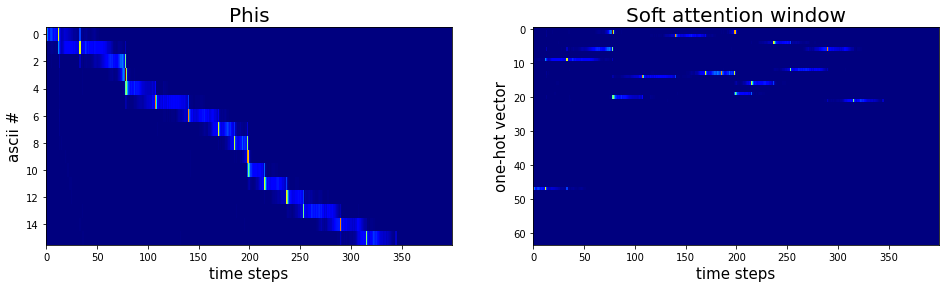

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


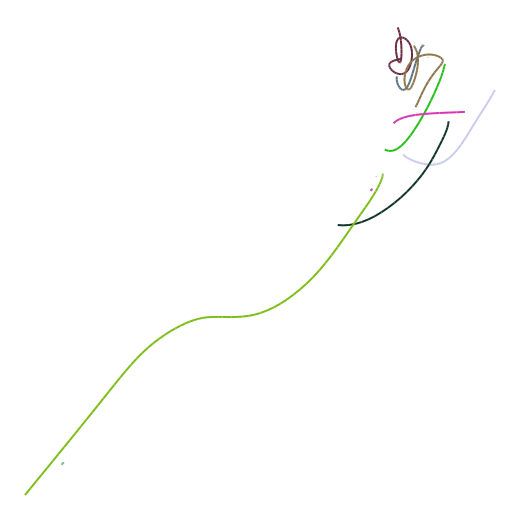

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


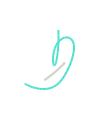

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


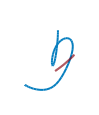

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


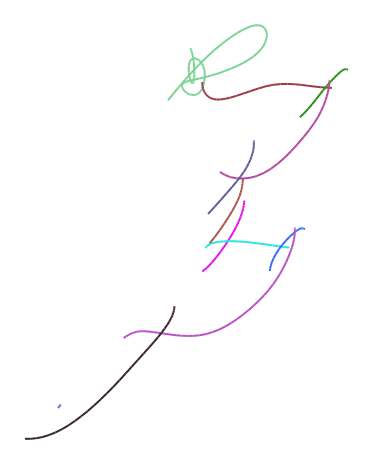

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


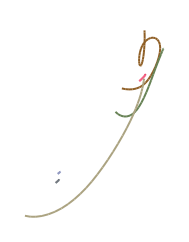

Epoch :  0  - step  10 / 548  - loss  -130.2154541015625  in  22.05420207977295
Epoch :  0  - step  20 / 548  - loss  -181.7202606201172  in  11.824787139892578
Epoch :  0  - step  30 / 548  - loss  -210.6075897216797  in  11.918448686599731
Epoch :  0  - step  40 / 548  - loss  -176.86961364746094  in  12.265642404556274
Epoch :  0  - step  50 / 548  - loss  -266.6950378417969  in  11.861906290054321
Epoch :  0  - step  60 / 548  - loss  -211.5729217529297  in  11.7701416015625
Epoch :  0  - step  70 / 548  - loss  -185.3721466064453  in  11.786543369293213
Epoch :  0  - step  80 / 548  - loss  -208.14785766601562  in  11.7038733959198
Epoch :  0  - step  90 / 548  - loss  -204.3940887451172  in  12.06845211982727
Epoch :  0  - step  100 / 548  - loss  -133.5590057373047  in  11.61359190940857
of our associates whom he met


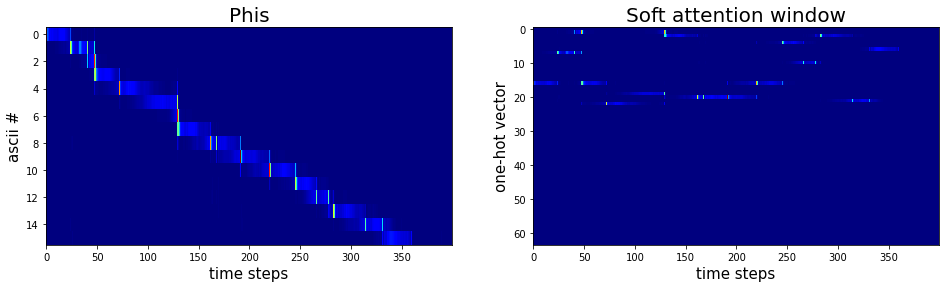

Epoch :  0  - step  110 / 548  - loss  -258.1097717285156  in  11.993138790130615
Epoch :  0  - step  120 / 548  - loss  -147.27842712402344  in  11.658092260360718
Epoch :  0  - step  130 / 548  - loss  -135.65371704101562  in  12.525159358978271
Epoch :  0  - step  140 / 548  - loss  -198.08372497558594  in  12.516696214675903
Epoch :  0  - step  150 / 548  - loss  -220.2853546142578  in  11.741801261901855
Epoch :  0  - step  160 / 548  - loss  -210.45303344726562  in  11.737655639648438
Epoch :  0  - step  170 / 548  - loss  -177.0431365966797  in  11.64360499382019
Epoch :  0  - step  180 / 548  - loss  -183.11582946777344  in  11.748018980026245
Epoch :  0  - step  190 / 548  - loss  -189.709228515625  in  12.155537128448486
Epoch :  0  - step  200 / 548  - loss  -98.727783203125  in  11.707092523574829
He rose and moved to the be


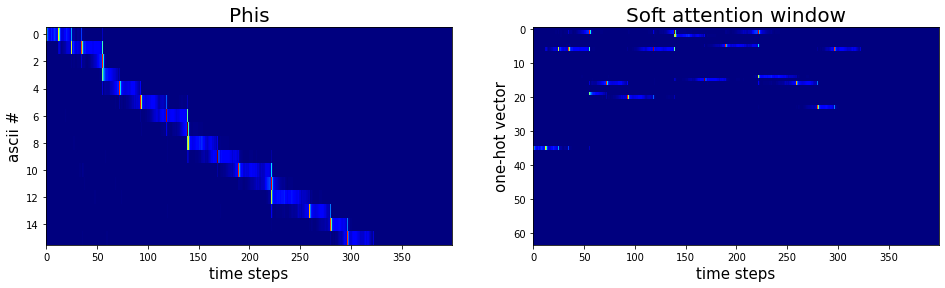

Epoch :  0  - step  210 / 548  - loss  -175.1869354248047  in  11.921004295349121
Epoch :  0  - step  220 / 548  - loss  -132.98190307617188  in  11.690998077392578
Epoch :  0  - step  230 / 548  - loss  -80.54251861572266  in  11.695626497268677
Epoch :  0  - step  240 / 548  - loss  -182.5257110595703  in  11.780818700790405
Epoch :  0  - step  250 / 548  - loss  -160.6754150390625  in  12.11720895767212
Epoch :  0  - step  260 / 548  - loss  -223.576416015625  in  11.63150429725647
Epoch :  0  - step  270 / 548  - loss  -195.5452117919922  in  11.713621377944946
Epoch :  0  - step  280 / 548  - loss  -201.1145477294922  in  11.606013774871826
Epoch :  0  - step  290 / 548  - loss  -173.41319274902344  in  11.621105432510376
Epoch :  0  - step  300 / 548  - loss  -182.0365753173828  in  12.121251106262207
without a hat on. He wanted to say


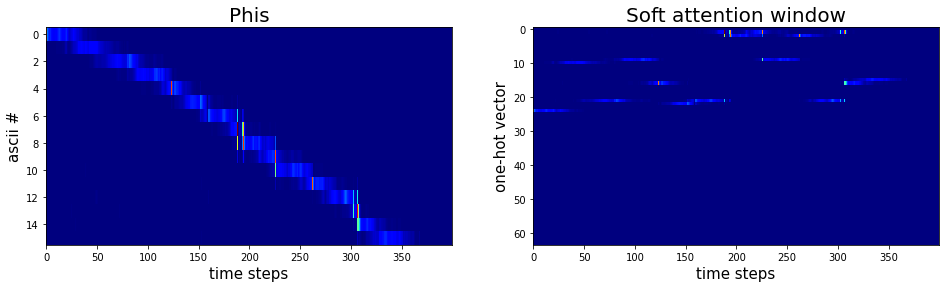

Epoch :  0  - step  310 / 548  - loss  -146.1554718017578  in  11.940404653549194
Epoch :  0  - step  320 / 548  - loss  -214.755859375  in  11.644401788711548
Epoch :  0  - step  330 / 548  - loss  -193.9427032470703  in  11.748615026473999
Epoch :  0  - step  340 / 548  - loss  -194.06155395507812  in  11.625701665878296
Epoch :  0  - step  350 / 548  - loss  -233.01123046875  in  12.18138337135315
Epoch :  0  - step  360 / 548  - loss  -194.4232177734375  in  11.729271173477173
Epoch :  0  - step  370 / 548  - loss  -161.15501403808594  in  11.670393943786621
Epoch :  0  - step  380 / 548  - loss  -188.6324462890625  in  11.717946529388428
Epoch :  0  - step  390 / 548  - loss  -212.25341796875  in  11.660035610198975
Epoch :  0  - step  400 / 548  - loss  -216.2763214111328  in  12.266193151473999
their bulwark. The smile on


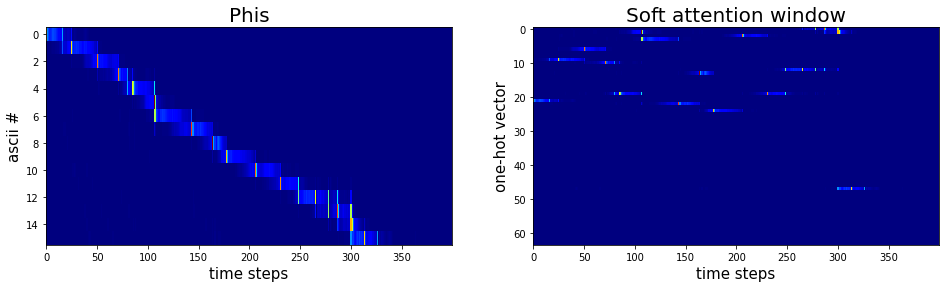

Epoch :  0  - step  410 / 548  - loss  -184.933837890625  in  12.028955459594727
Epoch :  0  - step  420 / 548  - loss  -153.6599578857422  in  11.644012451171875
Epoch :  0  - step  430 / 548  - loss  -116.59508514404297  in  11.666195392608643
Epoch :  0  - step  440 / 548  - loss  -128.0667266845703  in  11.853776693344116
Epoch :  0  - step  450 / 548  - loss  -215.0780792236328  in  12.083126068115234
Epoch :  0  - step  460 / 548  - loss  -167.9121856689453  in  11.642311573028564
Epoch :  0  - step  470 / 548  - loss  -172.95315551757812  in  11.780840396881104
Epoch :  0  - step  480 / 548  - loss  -213.896728515625  in  11.695510625839233
Epoch :  0  - step  490 / 548  - loss  -155.9024658203125  in  11.71321988105774
Epoch :  0  - step  500 / 548  - loss  -161.7952880859375  in  12.267567157745361
Montand . Against this couple


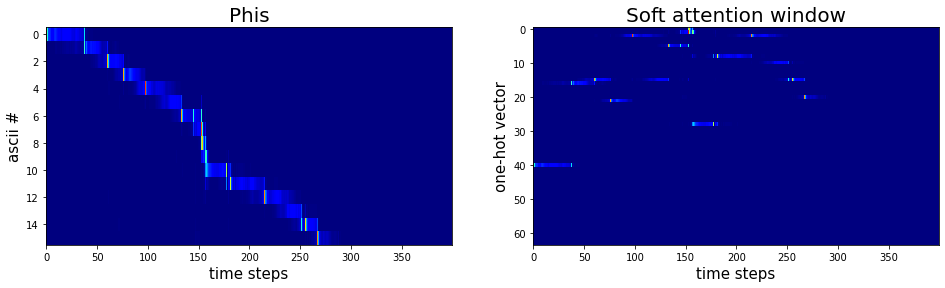

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


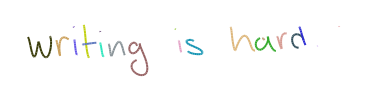

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


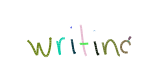

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


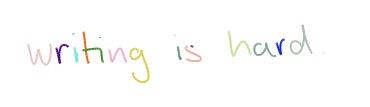

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


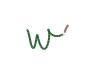

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


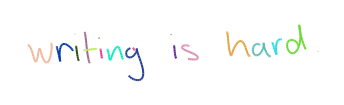

Epoch :  0  - step  510 / 548  - loss  -193.9290313720703  in  21.56304121017456
Epoch :  0  - step  520 / 548  - loss  -228.65696716308594  in  11.545218229293823
Epoch :  0  - step  530 / 548  - loss  -139.62289428710938  in  11.630191564559937
Epoch :  0  - step  540 / 548  - loss  -154.81529235839844  in  12.02908730506897
pointer reset
Epoch :  1  - step  0 / 548  - loss  -149.1461639404297  in  9.360500812530518
stitch with which you intend to


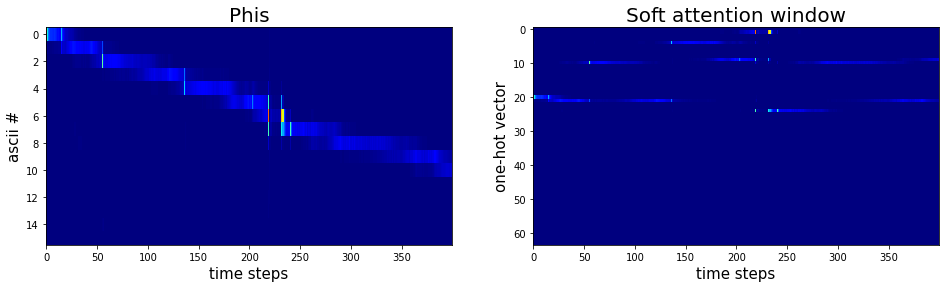

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


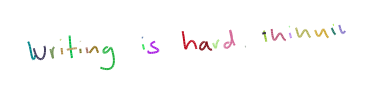

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


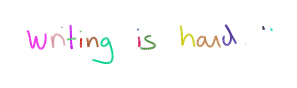

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


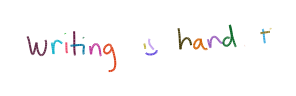

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


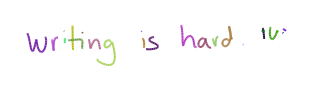

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


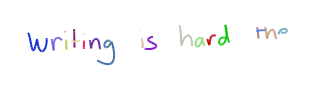

Epoch :  1  - step  10 / 548  - loss  -210.57861328125  in  21.70704221725464
Epoch :  1  - step  20 / 548  - loss  -153.9290008544922  in  11.528857946395874
Epoch :  1  - step  30 / 548  - loss  -187.09620666503906  in  11.475929737091064
Epoch :  1  - step  40 / 548  - loss  -118.77054595947266  in  12.081466913223267
Epoch :  1  - step  50 / 548  - loss  -274.4570617675781  in  11.624053716659546
Epoch :  1  - step  60 / 548  - loss  -228.0523681640625  in  11.649715423583984
Epoch :  1  - step  70 / 548  - loss  -166.4635009765625  in  11.69470477104187
Epoch :  1  - step  80 / 548  - loss  -76.71061706542969  in  11.494399547576904
Epoch :  1  - step  90 / 548  - loss  -218.4218292236328  in  12.194355964660645
Epoch :  1  - step  100 / 548  - loss  -203.21434020996094  in  11.514893054962158
covered by a previous report. A


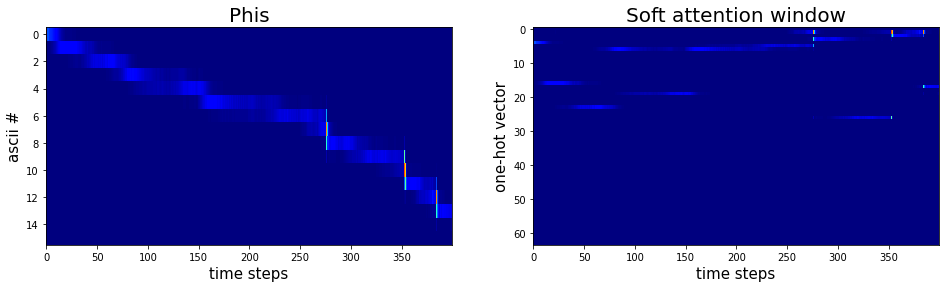

Epoch :  1  - step  110 / 548  - loss  -154.89683532714844  in  11.815567255020142
Epoch :  1  - step  120 / 548  - loss  -187.7938995361328  in  11.688637256622314
Epoch :  1  - step  130 / 548  - loss  -168.58985900878906  in  11.577721118927002
Epoch :  1  - step  140 / 548  - loss  -160.0592498779297  in  12.093799829483032
Epoch :  1  - step  150 / 548  - loss  -218.92247009277344  in  11.467522144317627
Epoch :  1  - step  160 / 548  - loss  -128.0584259033203  in  11.607479810714722
Epoch :  1  - step  170 / 548  - loss  -247.97817993164062  in  11.604433298110962
Epoch :  1  - step  180 / 548  - loss  -114.69268035888672  in  11.723518133163452
Epoch :  1  - step  190 / 548  - loss  -216.3466796875  in  12.028396844863892
Epoch :  1  - step  200 / 548  - loss  -160.14915466308594  in  11.60364031791687
about her, breathing the


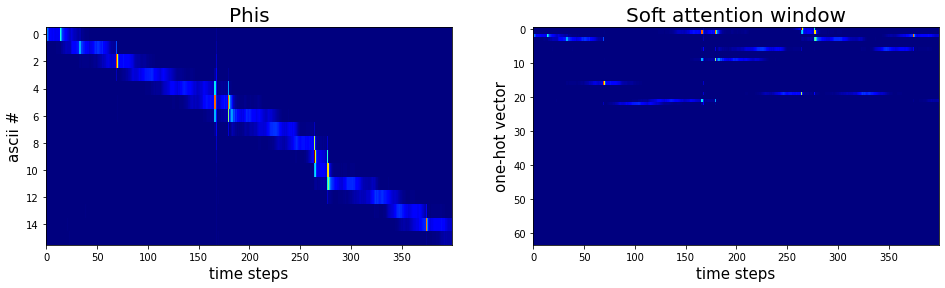

Epoch :  1  - step  210 / 548  - loss  -200.12625122070312  in  11.84127950668335
Epoch :  1  - step  220 / 548  - loss  -201.51390075683594  in  11.595282554626465
Epoch :  1  - step  230 / 548  - loss  -160.4706268310547  in  11.44819688796997
Epoch :  1  - step  240 / 548  - loss  -193.215576171875  in  11.911923885345459
Epoch :  1  - step  250 / 548  - loss  -202.5590057373047  in  11.554397821426392
Epoch :  1  - step  260 / 548  - loss  -195.99424743652344  in  11.4902503490448
Epoch :  1  - step  270 / 548  - loss  -203.1239471435547  in  11.529330253601074
Epoch :  1  - step  280 / 548  - loss  -165.2454071044922  in  11.393956899642944
Epoch :  1  - step  290 / 548  - loss  -210.0330810546875  in  11.83610224723816
Epoch :  1  - step  300 / 548  - loss  -243.88633728027344  in  11.418322563171387
we had words, I wouldn't


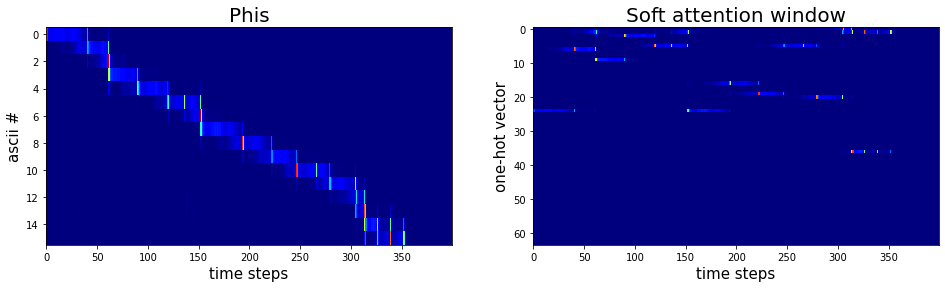

Epoch :  1  - step  310 / 548  - loss  -205.37071228027344  in  11.901009321212769
Epoch :  1  - step  320 / 548  - loss  -153.4729766845703  in  11.421349287033081
Epoch :  1  - step  330 / 548  - loss  -176.3426055908203  in  11.35049557685852
Epoch :  1  - step  340 / 548  - loss  -160.47657775878906  in  11.413455486297607
Epoch :  1  - step  350 / 548  - loss  -168.782470703125  in  12.09461784362793
Epoch :  1  - step  360 / 548  - loss  -170.80899047851562  in  11.344335794448853
Epoch :  1  - step  370 / 548  - loss  -206.431396484375  in  11.358635663986206
Epoch :  1  - step  380 / 548  - loss  -207.11865234375  in  11.449365139007568
Epoch :  1  - step  390 / 548  - loss  -194.3578643798828  in  11.353879690170288
Epoch :  1  - step  400 / 548  - loss  -126.4224624633789  in  12.021857738494873
girls dressed gracefully in sarong


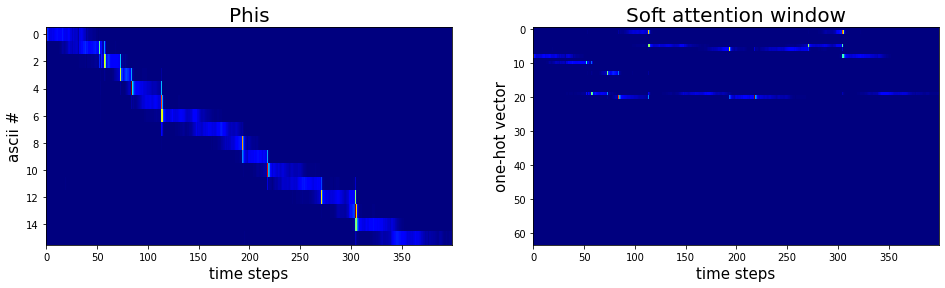

Epoch :  1  - step  410 / 548  - loss  -173.14439392089844  in  11.722212791442871
Epoch :  1  - step  420 / 548  - loss  -185.42752075195312  in  11.403541564941406
Epoch :  1  - step  430 / 548  - loss  -196.64007568359375  in  11.316100358963013
Epoch :  1  - step  440 / 548  - loss  -229.64768981933594  in  11.498687744140625
Epoch :  1  - step  450 / 548  - loss  -190.46694946289062  in  11.76805853843689
Epoch :  1  - step  460 / 548  - loss  -194.0443115234375  in  11.352530717849731
Epoch :  1  - step  470 / 548  - loss  -94.30389404296875  in  11.468444585800171
Epoch :  1  - step  480 / 548  - loss  -156.090576171875  in  11.530292987823486
Epoch :  1  - step  490 / 548  - loss  -165.27908325195312  in  11.412327289581299
Epoch :  1  - step  500 / 548  - loss  -148.30105590820312  in  11.839863777160645
kitchen a veritable oven of


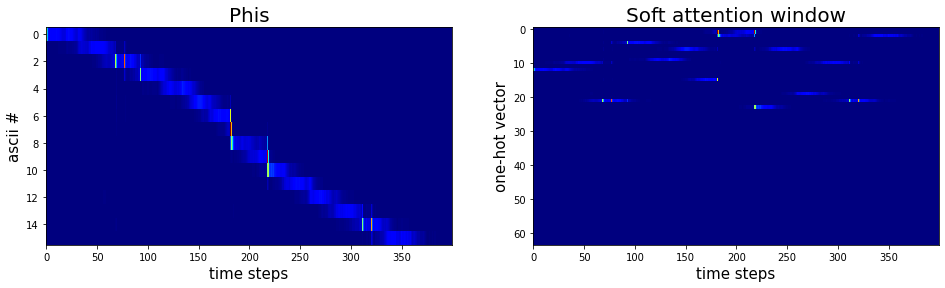

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


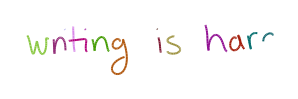

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


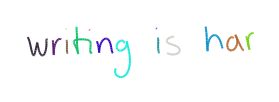

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


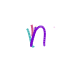

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


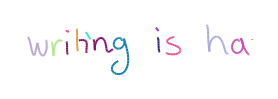

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


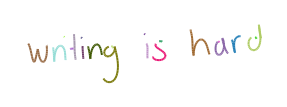

Epoch :  1  - step  510 / 548  - loss  -146.2355499267578  in  21.11807346343994
Epoch :  1  - step  520 / 548  - loss  -235.71435546875  in  11.558748245239258
Epoch :  1  - step  530 / 548  - loss  -110.0853042602539  in  11.453030109405518
Epoch :  1  - step  540 / 548  - loss  -131.13128662109375  in  11.807878971099854
pointer reset
Epoch :  2  - step  0 / 548  - loss  -227.60569763183594  in  9.215446949005127
Then he said slowly, "Yes, I believe


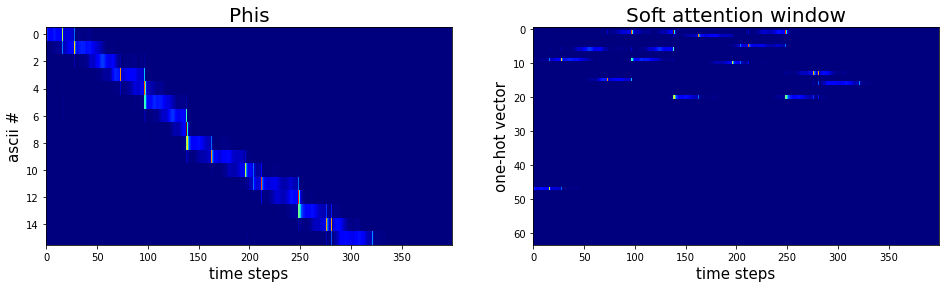

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


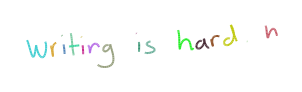

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


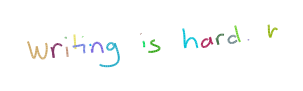

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


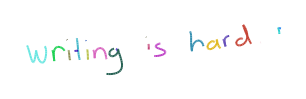

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


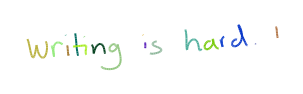

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


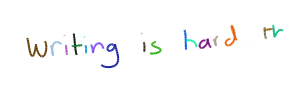

Epoch :  2  - step  10 / 548  - loss  -204.95193481445312  in  21.20280361175537
Epoch :  2  - step  20 / 548  - loss  -153.8384552001953  in  11.389554738998413
Epoch :  2  - step  30 / 548  - loss  -190.4051513671875  in  11.411457061767578
Epoch :  2  - step  40 / 548  - loss  -199.81103515625  in  11.762324333190918
Epoch :  2  - step  50 / 548  - loss  -210.4402313232422  in  11.43769383430481
Epoch :  2  - step  60 / 548  - loss  -173.07449340820312  in  11.421535730361938
Epoch :  2  - step  70 / 548  - loss  -152.33096313476562  in  11.369454860687256
Epoch :  2  - step  80 / 548  - loss  -197.0736083984375  in  11.484337091445923
Epoch :  2  - step  90 / 548  - loss  -184.12417602539062  in  11.785119771957397
Epoch :  2  - step  100 / 548  - loss  -166.14755249023438  in  11.37826156616211
Relations Office , Sir William Corell-Barnes


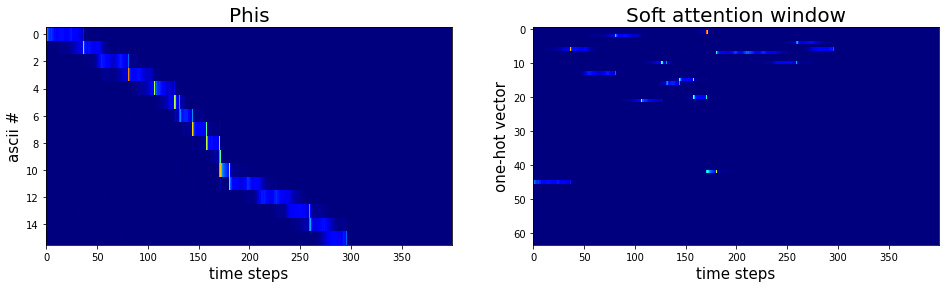

Epoch :  2  - step  110 / 548  - loss  -146.08091735839844  in  11.69404649734497
Epoch :  2  - step  120 / 548  - loss  -111.178955078125  in  11.373467683792114
Epoch :  2  - step  130 / 548  - loss  -175.9863739013672  in  11.494265079498291
Epoch :  2  - step  140 / 548  - loss  -136.5120086669922  in  11.787971258163452
Epoch :  2  - step  150 / 548  - loss  -205.78384399414062  in  11.506677865982056
Epoch :  2  - step  160 / 548  - loss  -220.0010986328125  in  11.373409748077393
Epoch :  2  - step  170 / 548  - loss  -229.64793395996094  in  11.337646007537842
Epoch :  2  - step  180 / 548  - loss  -147.301025390625  in  11.341447591781616
Epoch :  2  - step  190 / 548  - loss  -224.8369140625  in  11.314646005630493
Epoch :  2  - step  200 / 548  - loss  -172.123291015625  in  12.096967935562134
habitual to him but his eyes showed


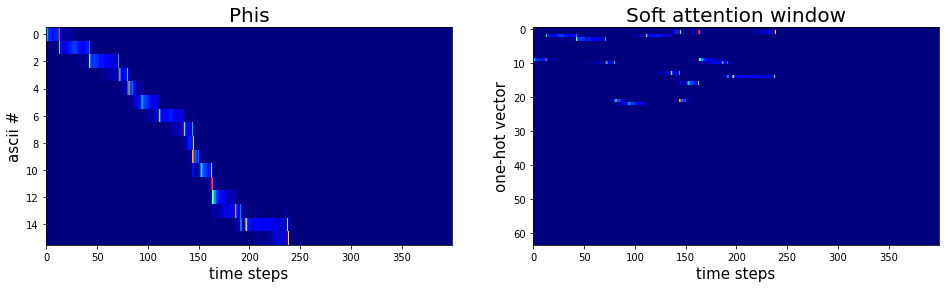

Epoch :  2  - step  210 / 548  - loss  -230.9610595703125  in  11.730750799179077
Epoch :  2  - step  220 / 548  - loss  -131.40103149414062  in  11.48545789718628
Epoch :  2  - step  230 / 548  - loss  -155.99461364746094  in  11.436805248260498
Epoch :  2  - step  240 / 548  - loss  -193.7379608154297  in  11.438816547393799
Epoch :  2  - step  250 / 548  - loss  -289.7619323730469  in  11.979226112365723
Epoch :  2  - step  260 / 548  - loss  -194.12619018554688  in  11.452819347381592
Epoch :  2  - step  270 / 548  - loss  -182.2380828857422  in  11.381885528564453
Epoch :  2  - step  280 / 548  - loss  -133.03736877441406  in  11.505838871002197
Epoch :  2  - step  290 / 548  - loss  -199.1195068359375  in  11.353630542755127
Epoch :  2  - step  300 / 548  - loss  -198.22325134277344  in  11.825440883636475
Sentence Database  C02-059


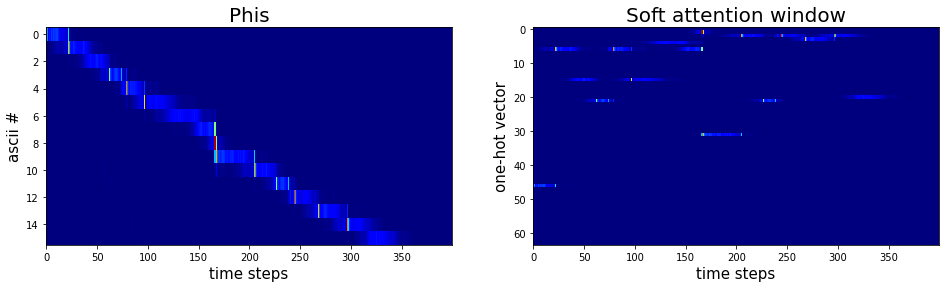

Epoch :  2  - step  310 / 548  - loss  -169.0764617919922  in  11.742947340011597
Epoch :  2  - step  320 / 548  - loss  -199.24996948242188  in  11.313551425933838
Epoch :  2  - step  330 / 548  - loss  -163.98512268066406  in  11.352590084075928
Epoch :  2  - step  340 / 548  - loss  -139.7996063232422  in  11.428470134735107
Epoch :  2  - step  350 / 548  - loss  -177.88584899902344  in  11.901957511901855
Epoch :  2  - step  360 / 548  - loss  -180.91488647460938  in  11.555297136306763
Epoch :  2  - step  370 / 548  - loss  -164.8778076171875  in  11.426549196243286
Epoch :  2  - step  380 / 548  - loss  -167.7971954345703  in  11.447278499603271
Epoch :  2  - step  390 / 548  - loss  -192.431640625  in  11.438060998916626
Epoch :  2  - step  400 / 548  - loss  -140.39488220214844  in  12.010042905807495
He dare not precipitate what might well be 


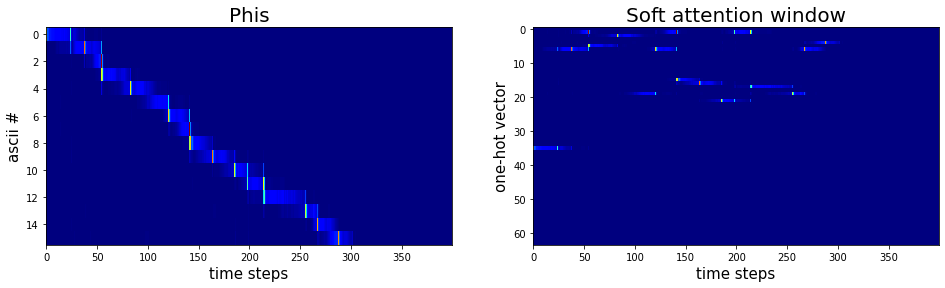

Epoch :  2  - step  410 / 548  - loss  -182.1490936279297  in  11.769607305526733
Epoch :  2  - step  420 / 548  - loss  -236.8433074951172  in  11.439253568649292
Epoch :  2  - step  430 / 548  - loss  -131.75881958007812  in  11.569804191589355
Epoch :  2  - step  440 / 548  - loss  -263.63055419921875  in  11.438813924789429
Epoch :  2  - step  450 / 548  - loss  -181.84304809570312  in  11.428103923797607
Epoch :  2  - step  460 / 548  - loss  -203.9727783203125  in  12.019568681716919
Epoch :  2  - step  470 / 548  - loss  -115.6262435913086  in  11.423433303833008
Epoch :  2  - step  480 / 548  - loss  -204.689453125  in  11.38315486907959
Epoch :  2  - step  490 / 548  - loss  -185.16929626464844  in  11.780267238616943
Epoch :  2  - step  500 / 548  - loss  -162.50250244140625  in  11.688087224960327
her luggage had disappeared and


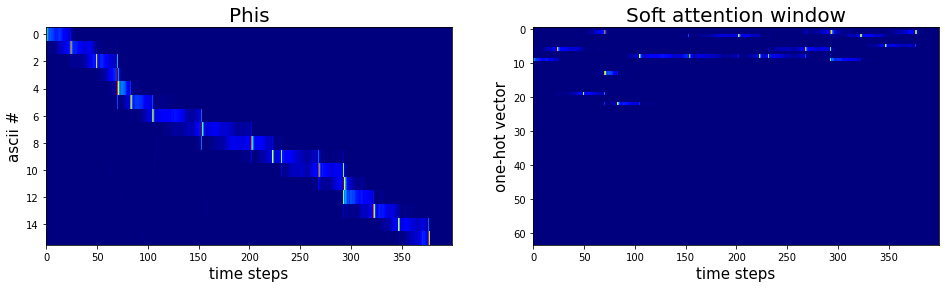

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


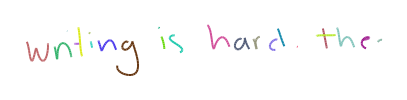

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


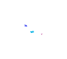

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


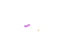

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


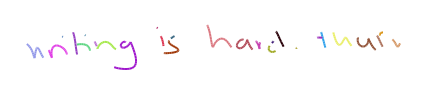

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


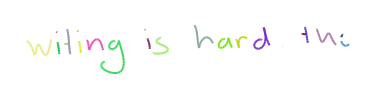

Epoch :  2  - step  510 / 548  - loss  -182.9959259033203  in  22.944685459136963
Epoch :  2  - step  520 / 548  - loss  -205.3623046875  in  11.677507400512695
Epoch :  2  - step  530 / 548  - loss  -233.5236358642578  in  11.451313018798828
Epoch :  2  - step  540 / 548  - loss  -160.0194091796875  in  11.560243129730225
pointer reset
Epoch :  3  - step  0 / 548  - loss  -186.87547302246094  in  9.741916418075562
received in great numbers in


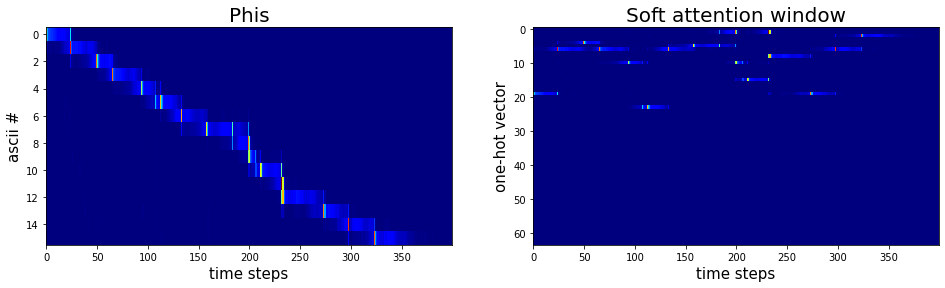

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


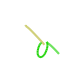

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


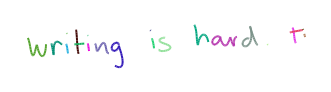

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


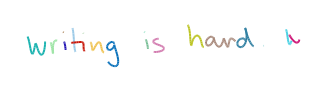

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


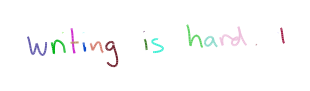

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


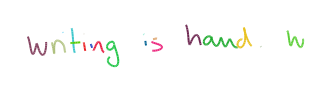

Epoch :  3  - step  10 / 548  - loss  -197.5775146484375  in  22.037593364715576
Epoch :  3  - step  20 / 548  - loss  -226.1230010986328  in  11.487151861190796
Epoch :  3  - step  30 / 548  - loss  -182.89784240722656  in  11.51910138130188
Epoch :  3  - step  40 / 548  - loss  -193.95828247070312  in  12.092072010040283
Epoch :  3  - step  50 / 548  - loss  -194.55503845214844  in  11.495985984802246
Epoch :  3  - step  60 / 548  - loss  -205.16299438476562  in  11.483136892318726
Epoch :  3  - step  70 / 548  - loss  -105.82970428466797  in  11.799773454666138
Epoch :  3  - step  80 / 548  - loss  -133.92335510253906  in  11.524783849716187
Epoch :  3  - step  90 / 548  - loss  -206.54039001464844  in  11.85854434967041
Epoch :  3  - step  100 / 548  - loss  -157.2776641845703  in  11.959874391555786
Vast gleaming counters await


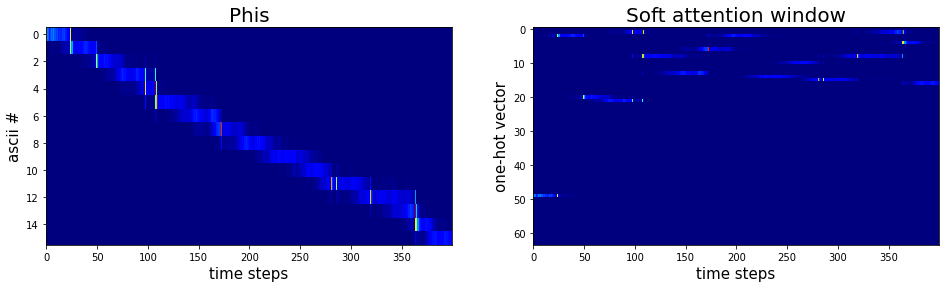

Epoch :  3  - step  110 / 548  - loss  -217.32778930664062  in  12.378625869750977
Epoch :  3  - step  120 / 548  - loss  -176.53201293945312  in  11.805673599243164
Epoch :  3  - step  130 / 548  - loss  -196.99258422851562  in  11.399199962615967
Epoch :  3  - step  140 / 548  - loss  -152.90672302246094  in  11.608301639556885
Epoch :  3  - step  150 / 548  - loss  -189.86727905273438  in  12.354015111923218
Epoch :  3  - step  160 / 548  - loss  -177.99139404296875  in  11.415960550308228
Epoch :  3  - step  170 / 548  - loss  -209.2037811279297  in  11.532969236373901
Epoch :  3  - step  180 / 548  - loss  -229.9895782470703  in  11.45470905303955
Epoch :  3  - step  190 / 548  - loss  -204.5760498046875  in  11.49577260017395
Epoch :  3  - step  200 / 548  - loss  -215.32998657226562  in  12.44229245185852
and choke. Again, with


/home/bobby/final_proj/final/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


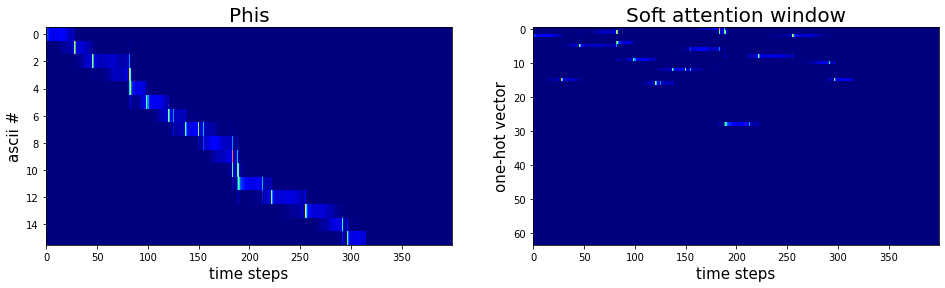

Epoch :  3  - step  210 / 548  - loss  -247.3670654296875  in  11.779225826263428
Epoch :  3  - step  220 / 548  - loss  -177.57115173339844  in  11.39297604560852
Epoch :  3  - step  230 / 548  - loss  -144.8085174560547  in  11.601963520050049
Epoch :  3  - step  240 / 548  - loss  -259.09869384765625  in  11.375305652618408
Epoch :  3  - step  250 / 548  - loss  -221.4701690673828  in  11.972763299942017
Epoch :  3  - step  260 / 548  - loss  -177.90992736816406  in  11.515779256820679
Epoch :  3  - step  270 / 548  - loss  -190.9363250732422  in  11.460607528686523
Epoch :  3  - step  280 / 548  - loss  -162.7923126220703  in  11.491487979888916
Epoch :  3  - step  290 / 548  - loss  -150.283203125  in  11.596029281616211
Epoch :  3  - step  300 / 548  - loss  -128.2524871826172  in  11.884285688400269
"You can." "I do it, Mister


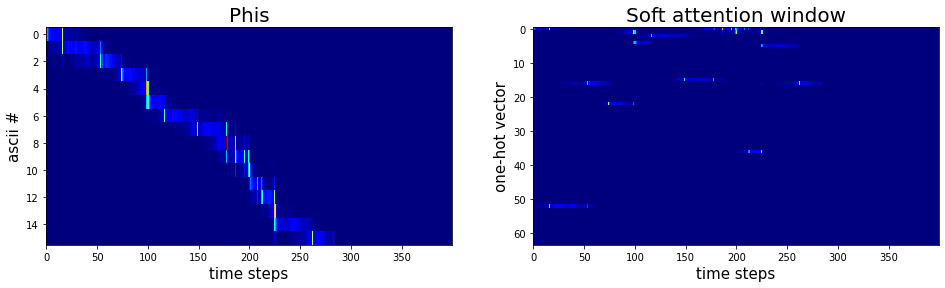

Epoch :  3  - step  310 / 548  - loss  -210.5155792236328  in  11.82336950302124
Epoch :  3  - step  320 / 548  - loss  -199.74668884277344  in  11.424488067626953
Epoch :  3  - step  330 / 548  - loss  -205.7514190673828  in  11.486953735351562
Epoch :  3  - step  340 / 548  - loss  -195.04507446289062  in  11.57006311416626
Epoch :  3  - step  350 / 548  - loss  -210.45201110839844  in  11.915982723236084
Epoch :  3  - step  360 / 548  - loss  -153.37771606445312  in  11.3971529006958
Epoch :  3  - step  370 / 548  - loss  -147.73948669433594  in  11.641350507736206
Epoch :  3  - step  380 / 548  - loss  -205.26536560058594  in  11.519280195236206
Epoch :  3  - step  390 / 548  - loss  -192.16928100585938  in  11.421815156936646
Epoch :  3  - step  400 / 548  - loss  -179.7283935546875  in  11.942049503326416
however, that a research


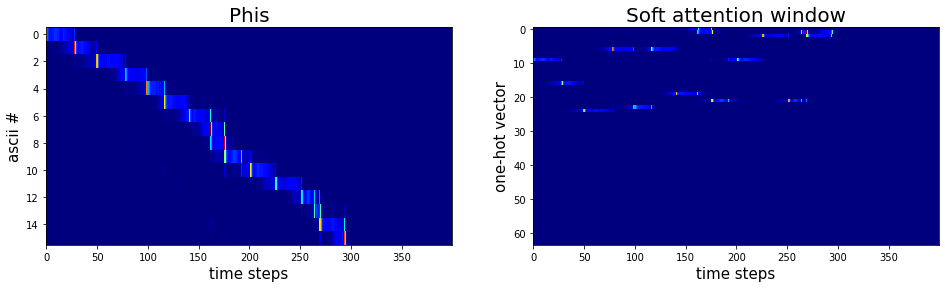

Epoch :  3  - step  410 / 548  - loss  -199.9911346435547  in  11.872454643249512
Epoch :  3  - step  420 / 548  - loss  -242.83731079101562  in  11.418638467788696
Epoch :  3  - step  430 / 548  - loss  -218.9453125  in  11.473801374435425
Epoch :  3  - step  440 / 548  - loss  -248.2500762939453  in  11.533358573913574
Epoch :  3  - step  450 / 548  - loss  -126.33902740478516  in  11.538367748260498
Epoch :  3  - step  460 / 548  - loss  -194.70449829101562  in  11.823922395706177
Epoch :  3  - step  470 / 548  - loss  -173.87258911132812  in  11.521377563476562
Epoch :  3  - step  480 / 548  - loss  -249.61875915527344  in  11.478540182113647
Epoch :  3  - step  490 / 548  - loss  -236.2139434814453  in  11.482586145401001
Epoch :  3  - step  500 / 548  - loss  -211.2653350830078  in  11.675312757492065
But, as I succumbed to the


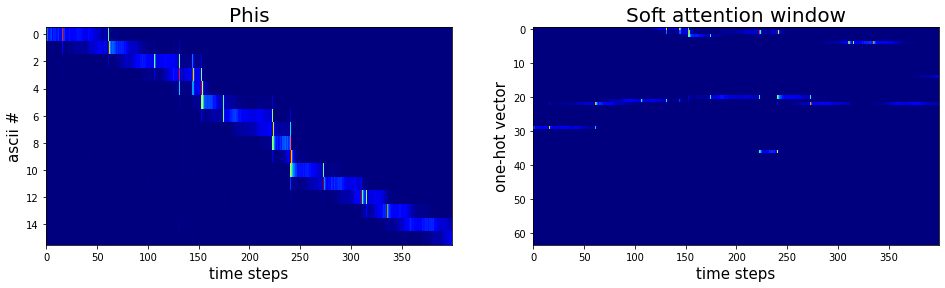

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


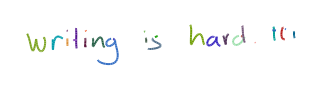

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


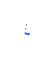

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


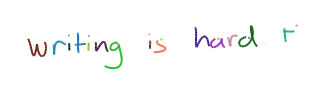

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


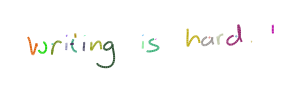

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


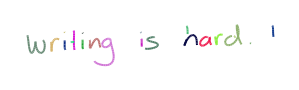

Epoch :  3  - step  510 / 548  - loss  -131.92889404296875  in  22.300964832305908
Epoch :  3  - step  520 / 548  - loss  -270.6294250488281  in  11.502631187438965
Epoch :  3  - step  530 / 548  - loss  -192.96392822265625  in  11.465360641479492
Epoch :  3  - step  540 / 548  - loss  -188.12966918945312  in  11.687246322631836
pointer reset
Epoch :  4  - step  0 / 548  - loss  -187.37417602539062  in  10.713579893112183
IN 1913 Dr . Burge , Bishop of Southwark


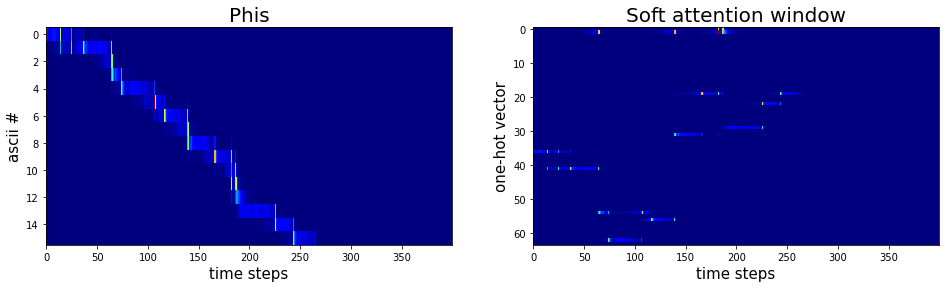

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


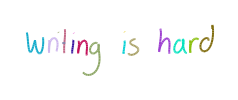

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


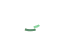

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


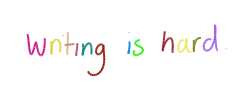

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


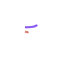

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


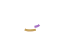

Epoch :  4  - step  10 / 548  - loss  -185.53346252441406  in  21.31983256340027
Epoch :  4  - step  20 / 548  - loss  -148.4759979248047  in  11.60171365737915
Epoch :  4  - step  30 / 548  - loss  -212.1392364501953  in  11.679578304290771
Epoch :  4  - step  40 / 548  - loss  -215.3363800048828  in  12.151319026947021
Epoch :  4  - step  50 / 548  - loss  -182.19497680664062  in  11.52771282196045
Epoch :  4  - step  60 / 548  - loss  -180.90078735351562  in  11.630947589874268
Epoch :  4  - step  70 / 548  - loss  -232.5785675048828  in  11.65859317779541
Epoch :  4  - step  80 / 548  - loss  -206.9732208251953  in  12.01081371307373
Epoch :  4  - step  90 / 548  - loss  -157.1069793701172  in  12.0910062789917
Epoch :  4  - step  100 / 548  - loss  -188.79209899902344  in  11.43293285369873
ninety-one minute hymn to


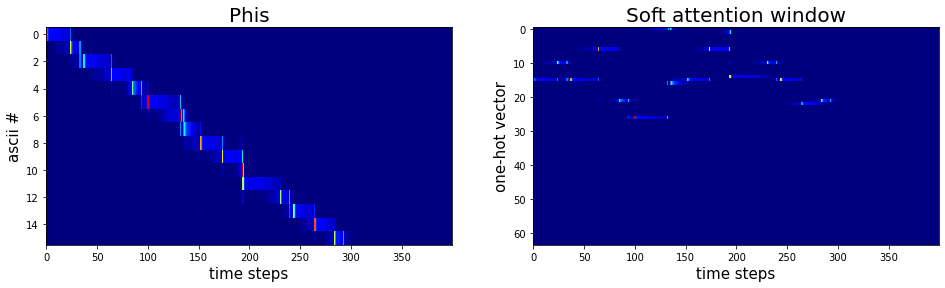

Epoch :  4  - step  110 / 548  - loss  -221.1155242919922  in  11.923217058181763
Epoch :  4  - step  120 / 548  - loss  -216.0596466064453  in  11.778178930282593
Epoch :  4  - step  130 / 548  - loss  -167.32798767089844  in  11.560051679611206
Epoch :  4  - step  140 / 548  - loss  -165.16030883789062  in  11.70271372795105
Epoch :  4  - step  150 / 548  - loss  -188.22476196289062  in  12.049842119216919
Epoch :  4  - step  160 / 548  - loss  -153.26260375976562  in  11.574003219604492
Epoch :  4  - step  170 / 548  - loss  -200.1337432861328  in  11.526206016540527
Epoch :  4  - step  180 / 548  - loss  -152.6019287109375  in  11.545191049575806
Epoch :  4  - step  190 / 548  - loss  -186.1841278076172  in  11.604572534561157
Epoch :  4  - step  200 / 548  - loss  -166.79356384277344  in  12.168697118759155
"Oh, Lord of Lords! I commend


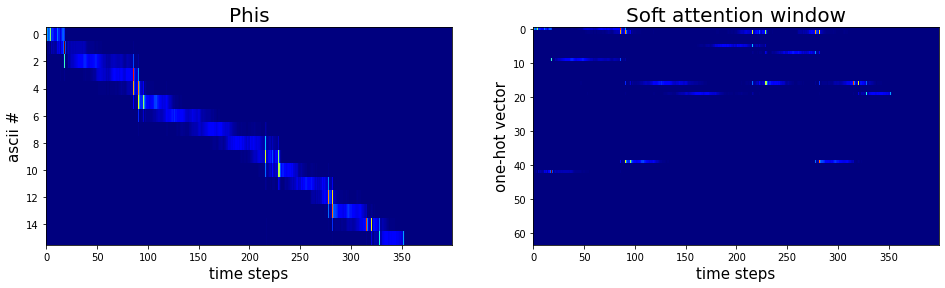

Epoch :  4  - step  210 / 548  - loss  -231.86680603027344  in  12.013387680053711
Epoch :  4  - step  220 / 548  - loss  -197.8407745361328  in  11.58639407157898
Epoch :  4  - step  230 / 548  - loss  -212.01089477539062  in  11.632190704345703
Epoch :  4  - step  240 / 548  - loss  -213.0915069580078  in  11.562150955200195
Epoch :  4  - step  250 / 548  - loss  -156.6201171875  in  12.274204730987549
Epoch :  4  - step  260 / 548  - loss  -184.7866668701172  in  11.640581607818604
Epoch :  4  - step  270 / 548  - loss  -180.1556396484375  in  11.501328468322754
Epoch :  4  - step  280 / 548  - loss  -177.51809692382812  in  11.502633810043335
Epoch :  4  - step  290 / 548  - loss  -173.8320770263672  in  11.514690160751343
Epoch :  4  - step  300 / 548  - loss  -260.1443176269531  in  12.54128909111023
Pauline stooped and began dabbing at the


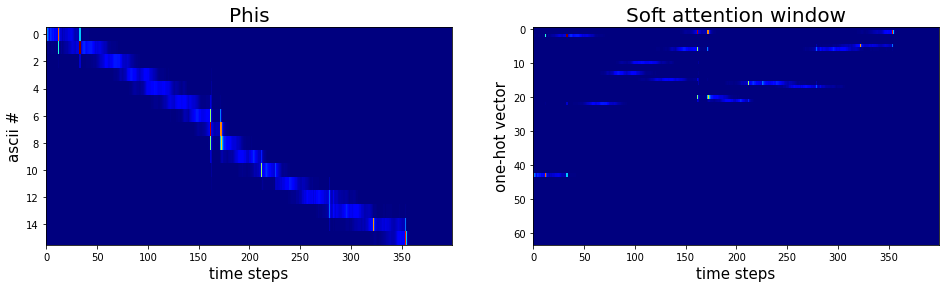

Epoch :  4  - step  310 / 548  - loss  -170.5224151611328  in  11.928521633148193
Epoch :  4  - step  320 / 548  - loss  -169.14268493652344  in  11.735490322113037
Epoch :  4  - step  330 / 548  - loss  -124.41584777832031  in  11.619632005691528
Epoch :  4  - step  340 / 548  - loss  -179.46231079101562  in  11.635766744613647
Epoch :  4  - step  350 / 548  - loss  -200.9649200439453  in  11.997556686401367
Epoch :  4  - step  360 / 548  - loss  -189.13906860351562  in  11.553139448165894
Epoch :  4  - step  370 / 548  - loss  -214.0522003173828  in  11.760555982589722
Epoch :  4  - step  380 / 548  - loss  -163.09181213378906  in  11.50088620185852
Epoch :  4  - step  390 / 548  - loss  -207.99839782714844  in  11.568751811981201
Epoch :  4  - step  400 / 548  - loss  -213.878662109375  in  12.012272357940674
you 'll drink - I 've seen your


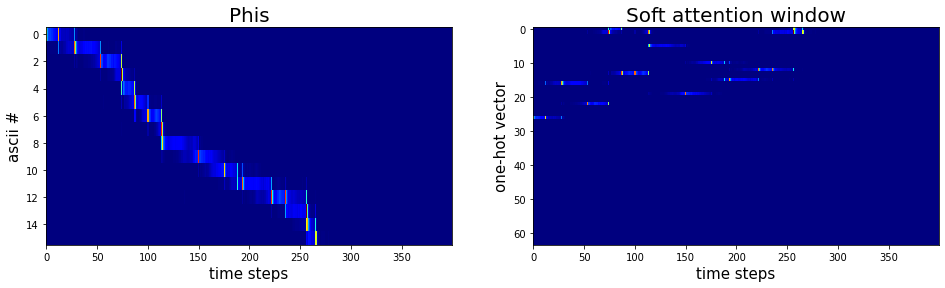

Epoch :  4  - step  410 / 548  - loss  -230.09288024902344  in  12.028040409088135
Epoch :  4  - step  420 / 548  - loss  -201.6116485595703  in  11.530914783477783
Epoch :  4  - step  430 / 548  - loss  -187.50367736816406  in  11.492591619491577
Epoch :  4  - step  440 / 548  - loss  -119.28081512451172  in  11.542770862579346
Epoch :  4  - step  450 / 548  - loss  -224.4827117919922  in  12.225529670715332
Epoch :  4  - step  460 / 548  - loss  -154.4130859375  in  11.730069160461426
Epoch :  4  - step  470 / 548  - loss  -234.362548828125  in  11.532012939453125
Epoch :  4  - step  480 / 548  - loss  -224.9276885986328  in  11.530318975448608
Epoch :  4  - step  490 / 548  - loss  -243.32852172851562  in  11.48861312866211
Epoch :  4  - step  500 / 548  - loss  -218.4608917236328  in  12.159704208374023
The darkness must have put him off


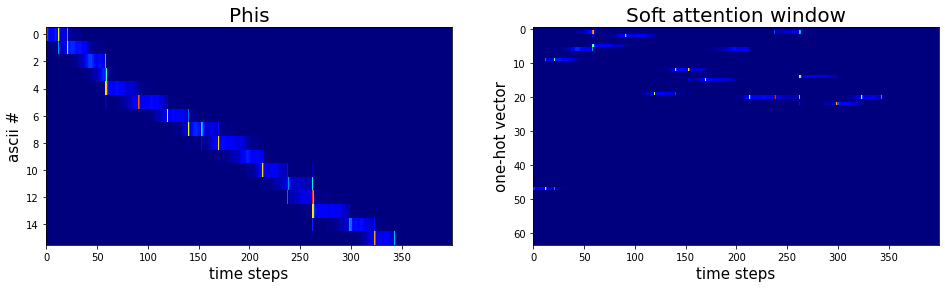

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


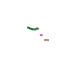

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


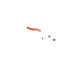

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


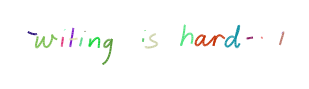

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


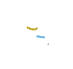

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


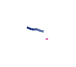

Epoch :  4  - step  510 / 548  - loss  -168.7742462158203  in  21.361891269683838
Epoch :  4  - step  520 / 548  - loss  -230.12388610839844  in  11.75428819656372
Epoch :  4  - step  530 / 548  - loss  -149.7732696533203  in  11.714248657226562
Epoch :  4  - step  540 / 548  - loss  -215.0927734375  in  11.567631721496582
pointer reset
Epoch :  5  - step  0 / 548  - loss  -214.80545043945312  in  10.541093349456787
name of a man he despised so heartily. He 


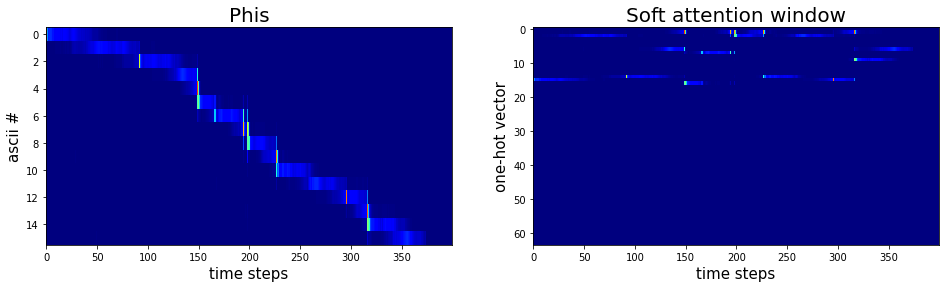

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


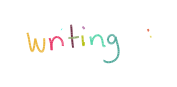

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


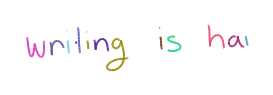

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


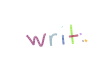

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


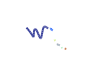

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


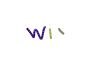

Epoch :  5  - step  10 / 548  - loss  -229.5498046875  in  21.491673469543457
Epoch :  5  - step  20 / 548  - loss  -130.92442321777344  in  11.92287564277649
Epoch :  5  - step  30 / 548  - loss  -165.2766571044922  in  11.57958698272705
Epoch :  5  - step  40 / 548  - loss  -153.12603759765625  in  12.060202836990356
Epoch :  5  - step  50 / 548  - loss  -157.702880859375  in  11.555070161819458
Epoch :  5  - step  60 / 548  - loss  -172.955810546875  in  11.740135669708252
Epoch :  5  - step  70 / 548  - loss  -203.85362243652344  in  11.54360055923462
Epoch :  5  - step  80 / 548  - loss  -136.0286102294922  in  11.51485276222229
Epoch :  5  - step  90 / 548  - loss  -203.22950744628906  in  12.442543029785156
Epoch :  5  - step  100 / 548  - loss  -180.14414978027344  in  11.545019388198853
Nobody 's going to shove ole


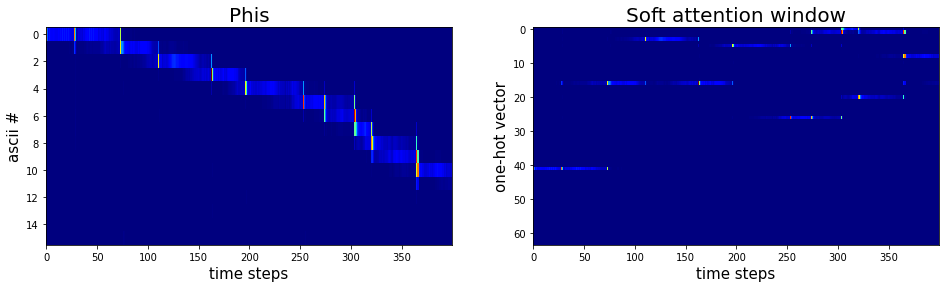

Epoch :  5  - step  110 / 548  - loss  -194.7787628173828  in  11.86386513710022
Epoch :  5  - step  120 / 548  - loss  -224.84378051757812  in  11.662357330322266
Epoch :  5  - step  130 / 548  - loss  -238.2536163330078  in  11.378497123718262
Epoch :  5  - step  140 / 548  - loss  -203.20977783203125  in  11.9963538646698
Epoch :  5  - step  150 / 548  - loss  -253.2065887451172  in  11.556510925292969
Epoch :  5  - step  160 / 548  - loss  -265.39080810546875  in  11.989131450653076
Epoch :  5  - step  170 / 548  - loss  -177.8817138671875  in  11.489463090896606
Epoch :  5  - step  180 / 548  - loss  -178.15623474121094  in  11.56137490272522
Epoch :  5  - step  190 / 548  - loss  -170.07522583007812  in  12.024109601974487
Epoch :  5  - step  200 / 548  - loss  -247.91995239257812  in  11.750245332717896
contemptuously threw them on the floor.


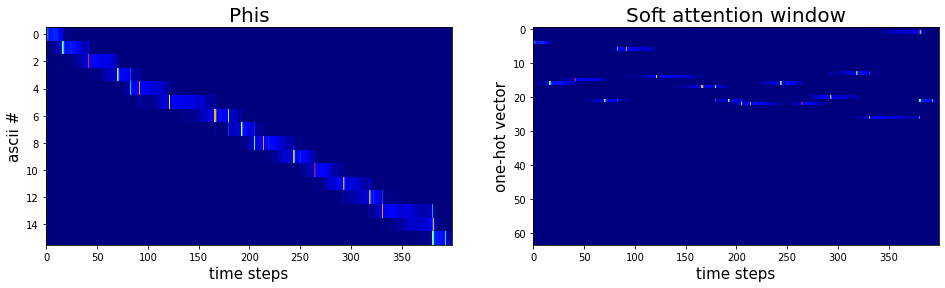

Epoch :  5  - step  210 / 548  - loss  -228.736572265625  in  12.265596866607666
Epoch :  5  - step  220 / 548  - loss  -196.7891387939453  in  11.677093267440796
Epoch :  5  - step  230 / 548  - loss  -181.1772003173828  in  11.800552129745483
Epoch :  5  - step  240 / 548  - loss  -239.31005859375  in  12.184608936309814
Epoch :  5  - step  250 / 548  - loss  -182.01870727539062  in  11.464189291000366
Epoch :  5  - step  260 / 548  - loss  -221.3920135498047  in  11.946315288543701
Epoch :  5  - step  270 / 548  - loss  -193.16860961914062  in  11.80808401107788
Epoch :  5  - step  280 / 548  - loss  -182.11277770996094  in  11.531326293945312
Epoch :  5  - step  290 / 548  - loss  -257.8419189453125  in  11.51418924331665
Epoch :  5  - step  300 / 548  - loss  -176.9776153564453  in  12.432015895843506
shops in the neighbourhoods and


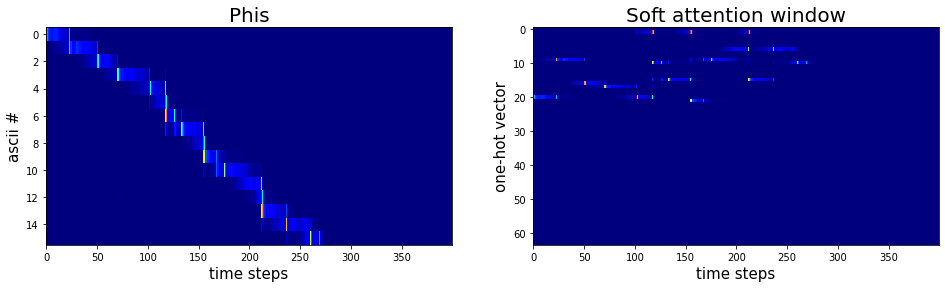

Epoch :  5  - step  310 / 548  - loss  -126.07427215576172  in  12.071686029434204
Epoch :  5  - step  320 / 548  - loss  -179.23191833496094  in  11.561011552810669
Epoch :  5  - step  330 / 548  - loss  -84.5081787109375  in  11.808499813079834
Epoch :  5  - step  340 / 548  - loss  -205.4334716796875  in  11.731791734695435
Epoch :  5  - step  350 / 548  - loss  -226.6112060546875  in  12.058952331542969
Epoch :  5  - step  360 / 548  - loss  -201.05747985839844  in  11.854447841644287
Epoch :  5  - step  370 / 548  - loss  -184.51046752929688  in  11.988741636276245
Epoch :  5  - step  380 / 548  - loss  -166.67672729492188  in  11.957276582717896
Epoch :  5  - step  390 / 548  - loss  -282.9457702636719  in  11.537530422210693
Epoch :  5  - step  400 / 548  - loss  -156.28990173339844  in  12.16176986694336
from his travels it might have been


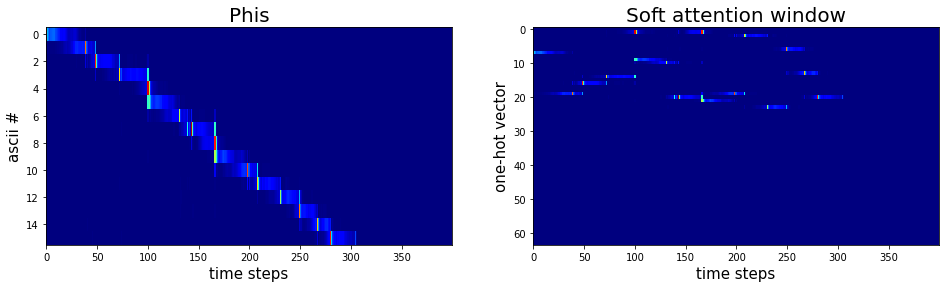

Epoch :  5  - step  410 / 548  - loss  -215.819091796875  in  12.282820224761963
Epoch :  5  - step  420 / 548  - loss  -206.7781524658203  in  11.60969352722168
Epoch :  5  - step  430 / 548  - loss  -216.5789031982422  in  11.4275381565094
Epoch :  5  - step  440 / 548  - loss  -204.11497497558594  in  11.663161993026733
Epoch :  5  - step  450 / 548  - loss  -201.5406951904297  in  12.783536195755005
Epoch :  5  - step  460 / 548  - loss  -220.5452117919922  in  11.781858682632446
Epoch :  5  - step  470 / 548  - loss  -217.4396514892578  in  11.63692045211792
Epoch :  5  - step  480 / 548  - loss  -196.89979553222656  in  11.6105055809021
Epoch :  5  - step  490 / 548  - loss  -176.27520751953125  in  11.439139127731323
Epoch :  5  - step  500 / 548  - loss  -224.36241149902344  in  13.018031358718872
"Because we know all things", the


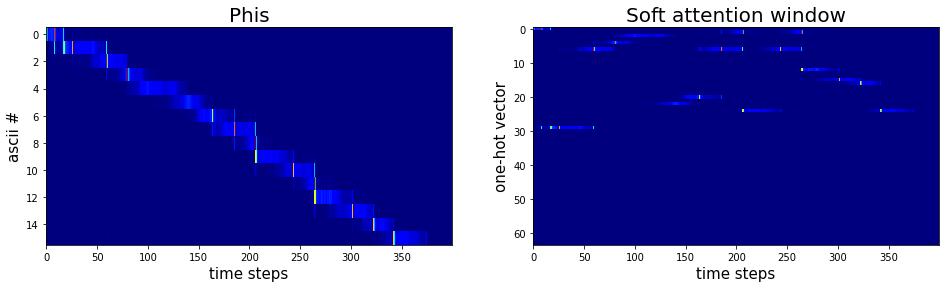

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


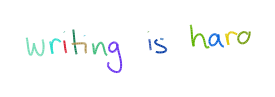

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


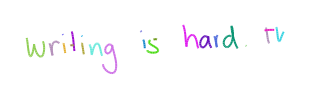

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


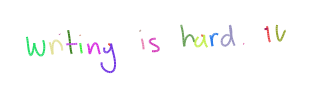

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


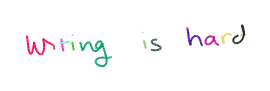

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


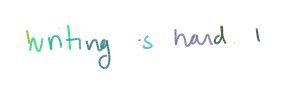

Epoch :  5  - step  510 / 548  - loss  -245.59690856933594  in  21.436909437179565
Epoch :  5  - step  520 / 548  - loss  -199.0071258544922  in  11.708375692367554
Epoch :  5  - step  530 / 548  - loss  -198.76536560058594  in  11.859576940536499
Epoch :  5  - step  540 / 548  - loss  -235.90135192871094  in  12.66022777557373
pointer reset
Epoch :  6  - step  0 / 548  - loss  -227.7888641357422  in  9.345232963562012
in local government , compared with the


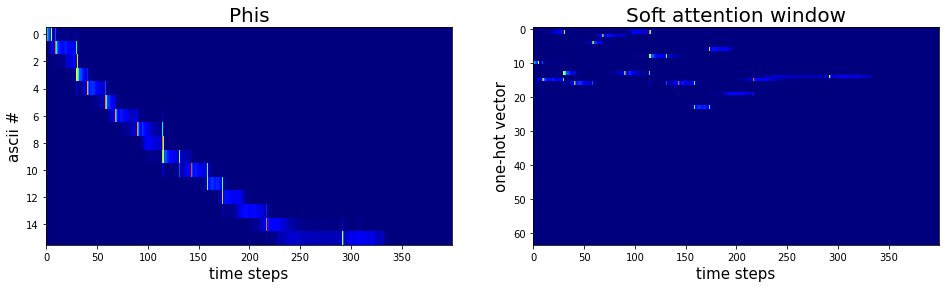

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


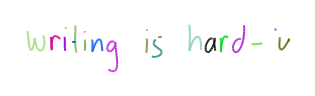

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


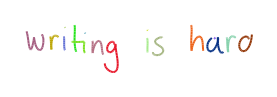

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


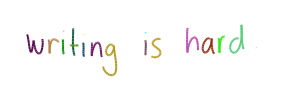

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


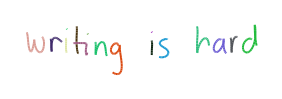

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


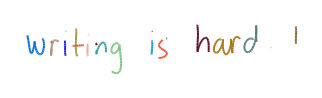

Epoch :  6  - step  10 / 548  - loss  -181.7718048095703  in  21.216527938842773
Epoch :  6  - step  20 / 548  - loss  -191.8853759765625  in  11.514472961425781
Epoch :  6  - step  30 / 548  - loss  -162.05458068847656  in  12.160706043243408
Epoch :  6  - step  40 / 548  - loss  -269.276123046875  in  11.59866213798523
Epoch :  6  - step  50 / 548  - loss  -258.0498962402344  in  11.578791379928589
Epoch :  6  - step  60 / 548  - loss  -226.0797119140625  in  11.78103494644165
Epoch :  6  - step  70 / 548  - loss  -224.2094268798828  in  11.79443621635437
Epoch :  6  - step  80 / 548  - loss  -220.76780700683594  in  11.949763774871826
Epoch :  6  - step  90 / 548  - loss  -198.4369659423828  in  11.510120391845703
Epoch :  6  - step  100 / 548  - loss  -187.664306640625  in  11.720523118972778
unpleasant was to be faced.


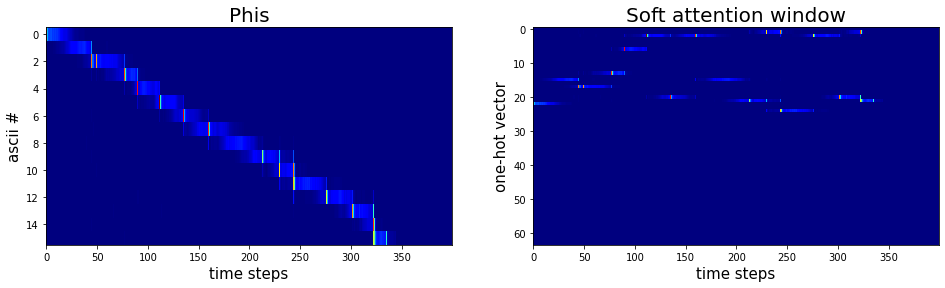

Epoch :  6  - step  110 / 548  - loss  -213.981689453125  in  12.305330276489258
Epoch :  6  - step  120 / 548  - loss  -135.57437133789062  in  11.604990243911743
Epoch :  6  - step  130 / 548  - loss  -240.1697998046875  in  11.642862796783447
Epoch :  6  - step  140 / 548  - loss  -212.47000122070312  in  11.956810235977173
Epoch :  6  - step  150 / 548  - loss  -204.2279815673828  in  11.811704635620117
Epoch :  6  - step  160 / 548  - loss  -169.7061004638672  in  11.521457195281982
Epoch :  6  - step  170 / 548  - loss  -235.7109832763672  in  11.477030277252197
Epoch :  6  - step  180 / 548  - loss  -151.20555114746094  in  11.673660039901733
Epoch :  6  - step  190 / 548  - loss  -208.2803497314453  in  12.050605058670044
Epoch :  6  - step  200 / 548  - loss  -221.68289184570312  in  11.70623517036438
but rather he wants to show the


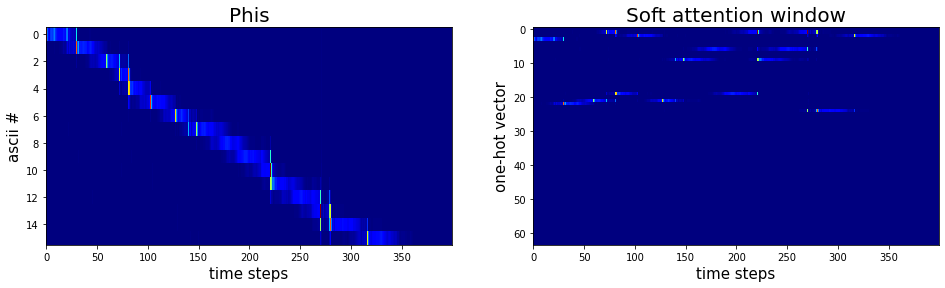

Epoch :  6  - step  210 / 548  - loss  -258.4104919433594  in  11.855266332626343
Epoch :  6  - step  220 / 548  - loss  -209.43736267089844  in  11.438417434692383
Epoch :  6  - step  230 / 548  - loss  -288.3060607910156  in  11.545784950256348
Epoch :  6  - step  240 / 548  - loss  -176.94651794433594  in  12.034708738327026
Epoch :  6  - step  250 / 548  - loss  -192.25192260742188  in  12.197039127349854
Epoch :  6  - step  260 / 548  - loss  -203.77879333496094  in  12.105575799942017
Epoch :  6  - step  270 / 548  - loss  -137.94564819335938  in  11.557482242584229
Epoch :  6  - step  280 / 548  - loss  -292.833740234375  in  11.506035327911377
Epoch :  6  - step  290 / 548  - loss  -136.6689910888672  in  11.916155338287354
Epoch :  6  - step  300 / 548  - loss  -222.0459442138672  in  11.587942123413086
Be pleased to alight. " I think, " she 


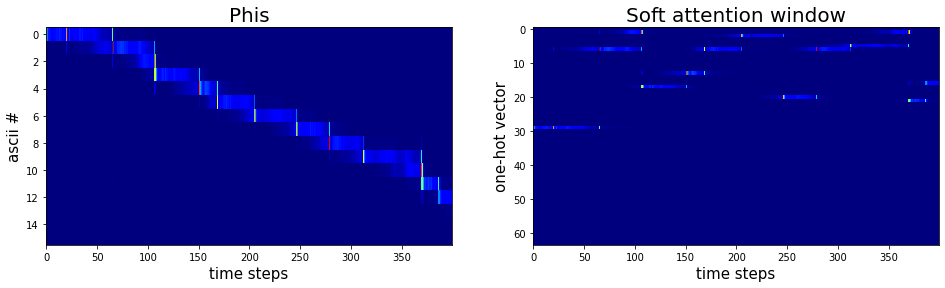

Epoch :  6  - step  310 / 548  - loss  -255.6682586669922  in  11.725690841674805
Epoch :  6  - step  320 / 548  - loss  -250.4116973876953  in  11.506874084472656
Epoch :  6  - step  330 / 548  - loss  -188.6902313232422  in  11.75725769996643
Epoch :  6  - step  340 / 548  - loss  -179.75425720214844  in  11.894891500473022
Epoch :  6  - step  350 / 548  - loss  -225.4692840576172  in  11.631946802139282
Epoch :  6  - step  360 / 548  - loss  -239.83848571777344  in  11.527719736099243
Epoch :  6  - step  370 / 548  - loss  -199.86216735839844  in  11.801262378692627
Epoch :  6  - step  380 / 548  - loss  -193.35203552246094  in  12.115866899490356
Epoch :  6  - step  390 / 548  - loss  -232.6106414794922  in  12.121045589447021
Epoch :  6  - step  400 / 548  - loss  -153.2016143798828  in  11.485733270645142
a bit of luck on the three-thirty.


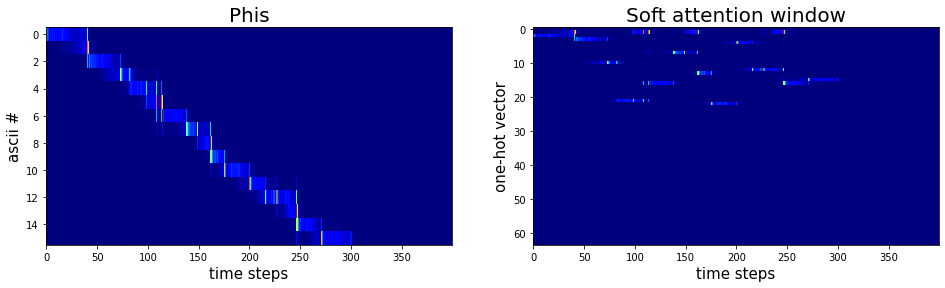

Epoch :  6  - step  410 / 548  - loss  -191.39187622070312  in  11.93169093132019
Epoch :  6  - step  420 / 548  - loss  -212.4757843017578  in  12.365033149719238
Epoch :  6  - step  430 / 548  - loss  -158.9420928955078  in  11.599127054214478
Epoch :  6  - step  440 / 548  - loss  -146.7554168701172  in  12.035999536514282
Epoch :  6  - step  450 / 548  - loss  -139.6316680908203  in  11.534725904464722
Epoch :  6  - step  460 / 548  - loss  -290.8633728027344  in  11.437611818313599
Epoch :  6  - step  470 / 548  - loss  -191.06900024414062  in  11.55617380142212
Epoch :  6  - step  480 / 548  - loss  -163.67430114746094  in  11.578145027160645
Epoch :  6  - step  490 / 548  - loss  -140.927001953125  in  11.754465103149414
Epoch :  6  - step  500 / 548  - loss  -178.9796142578125  in  11.743046760559082
Welcome experiment. Penalty-shot


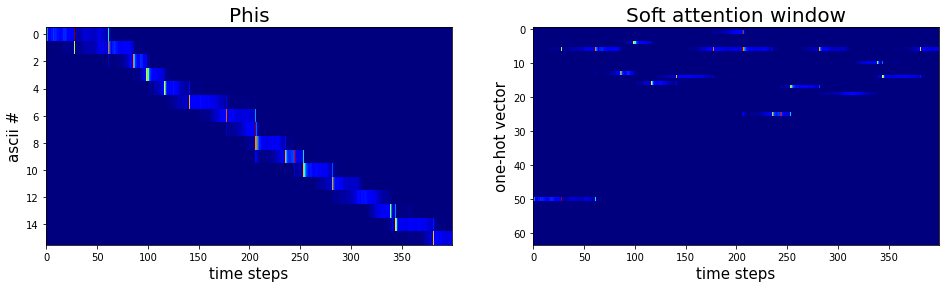

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


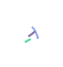

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


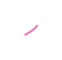

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


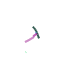

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


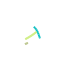

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


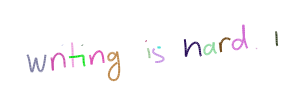

Epoch :  6  - step  510 / 548  - loss  -209.58792114257812  in  21.73172378540039
Epoch :  6  - step  520 / 548  - loss  -234.6826171875  in  12.098976373672485
Epoch :  6  - step  530 / 548  - loss  -116.0381851196289  in  11.73473334312439
Epoch :  6  - step  540 / 548  - loss  -223.4794921875  in  12.062900066375732
pointer reset
Epoch :  7  - step  0 / 548  - loss  -236.83706665039062  in  9.331113815307617
levels in training and operations.


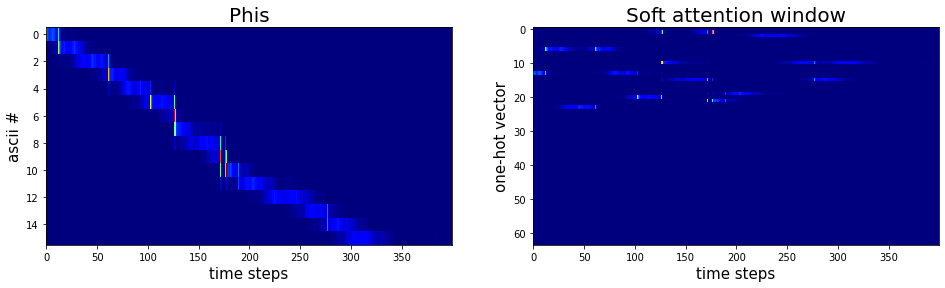

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


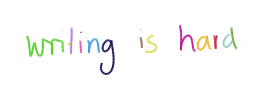

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


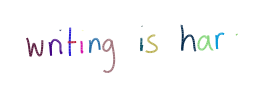

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


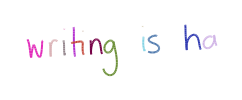

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


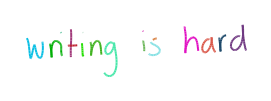

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


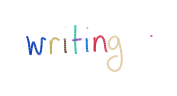

KeyboardInterrupt: 

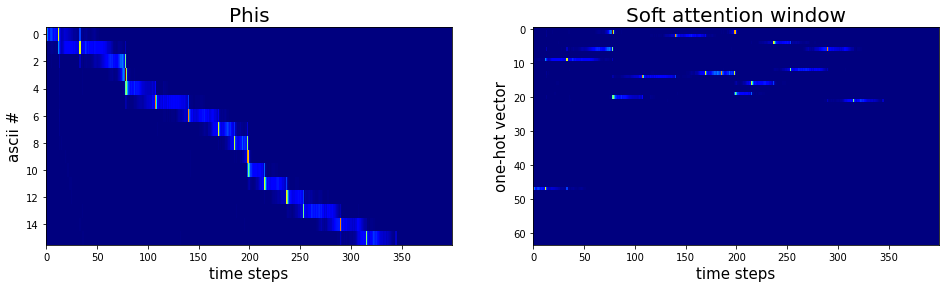

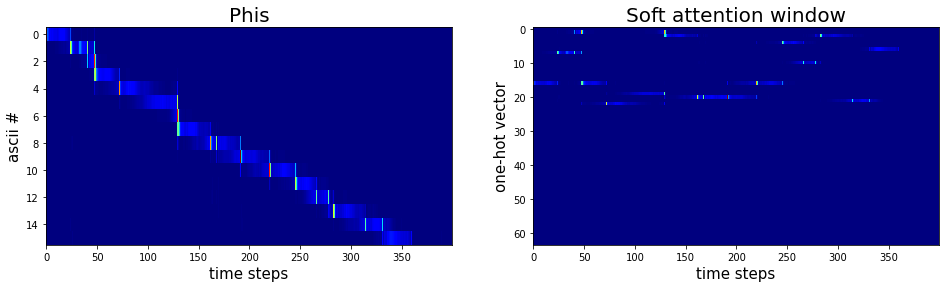

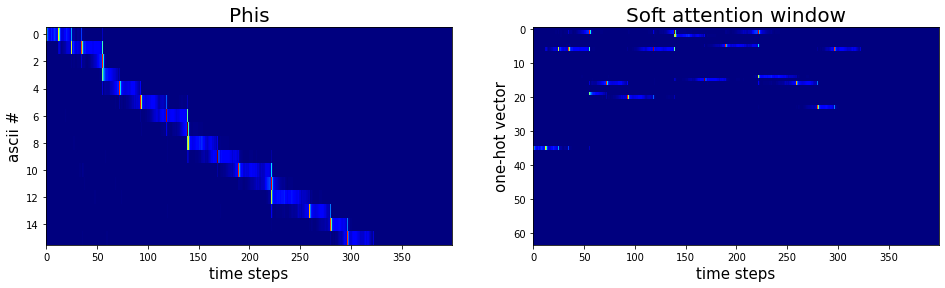

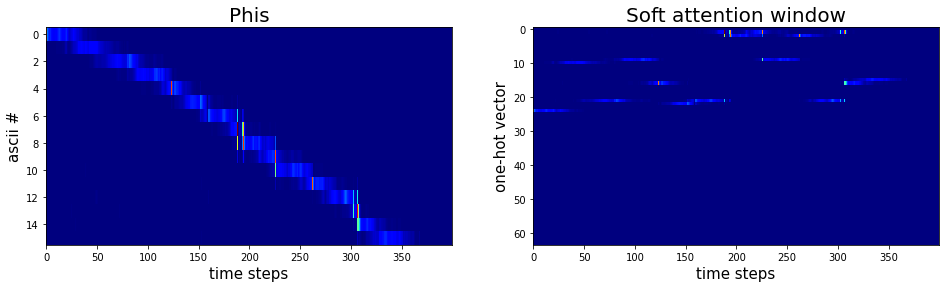

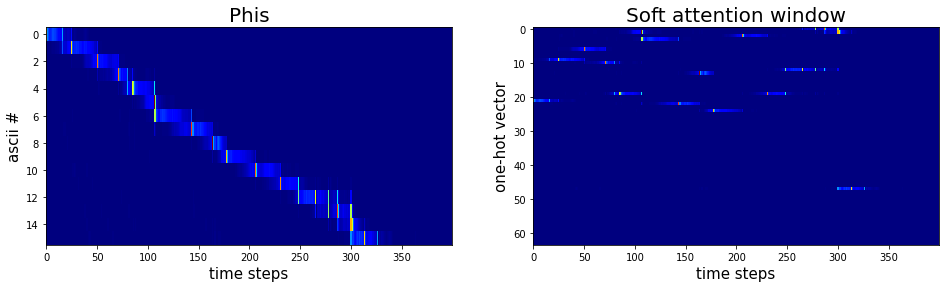

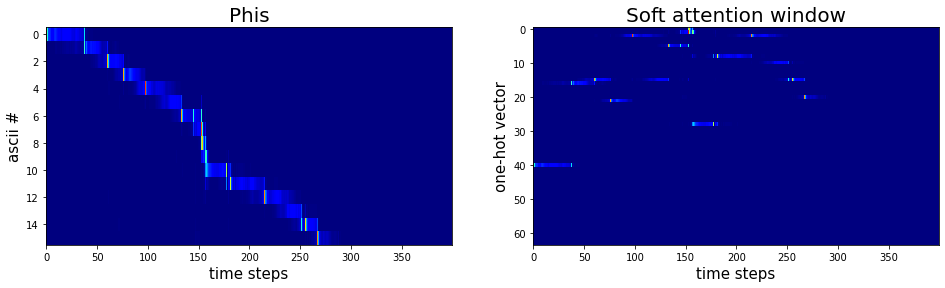

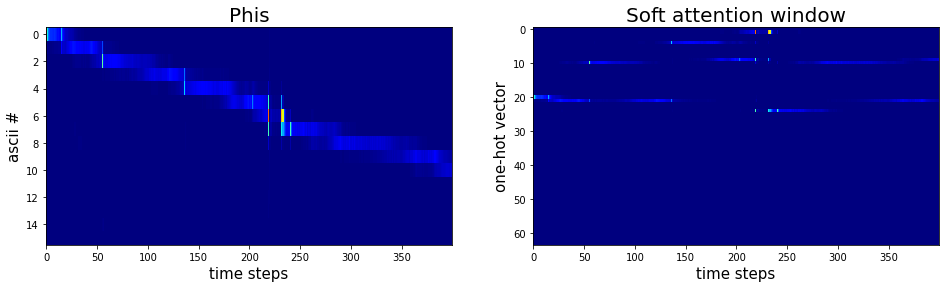

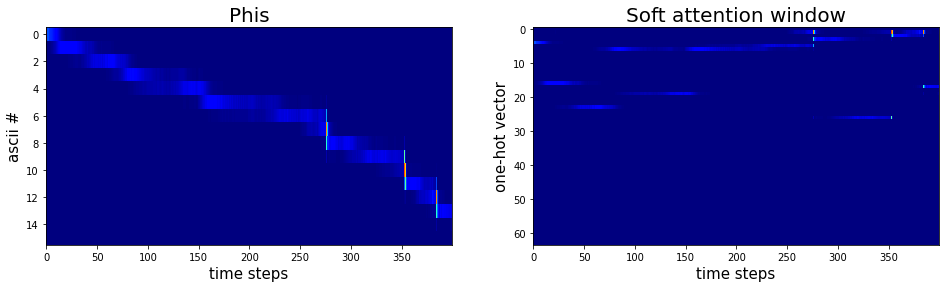

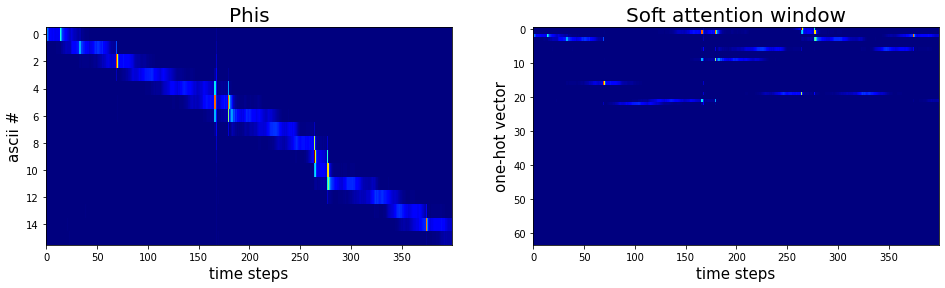

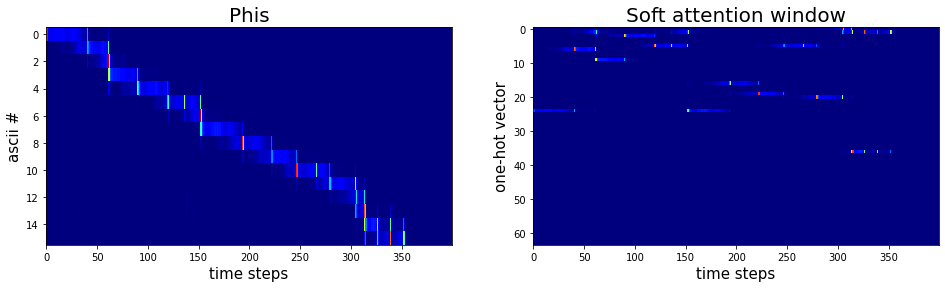

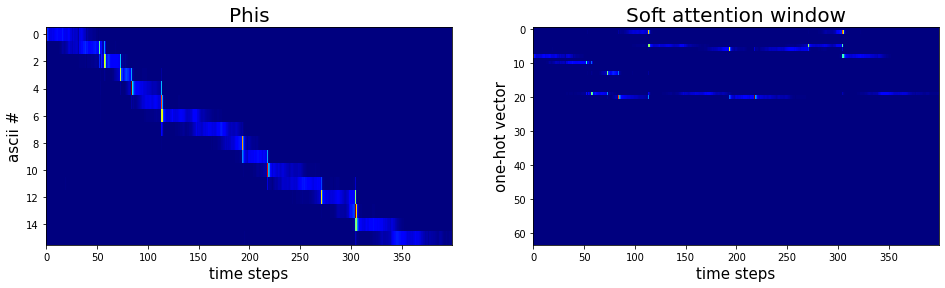

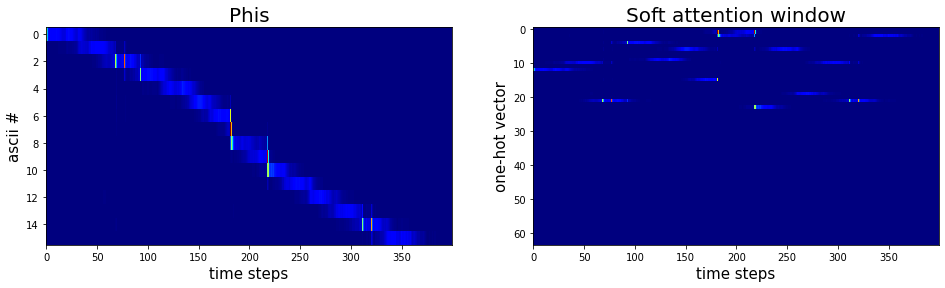

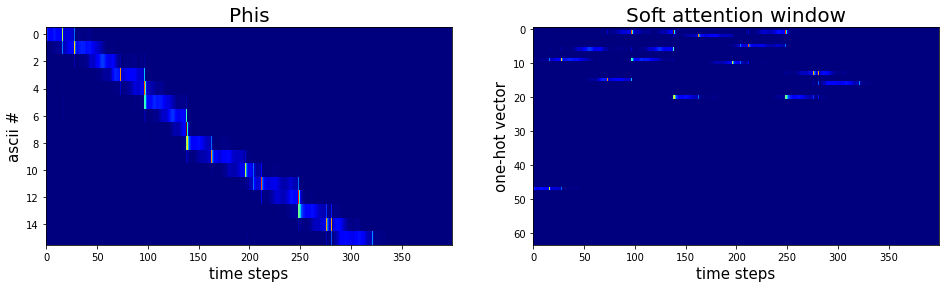

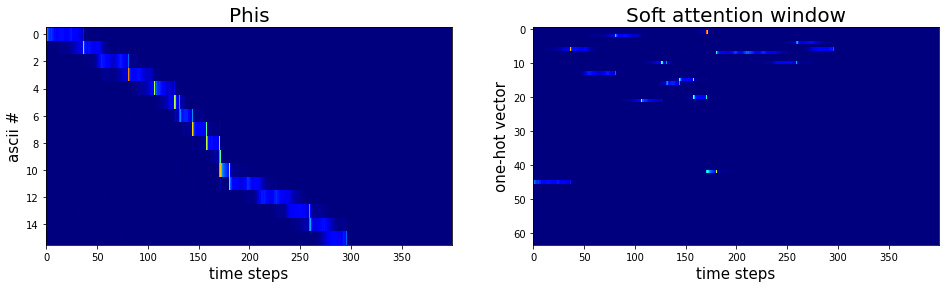

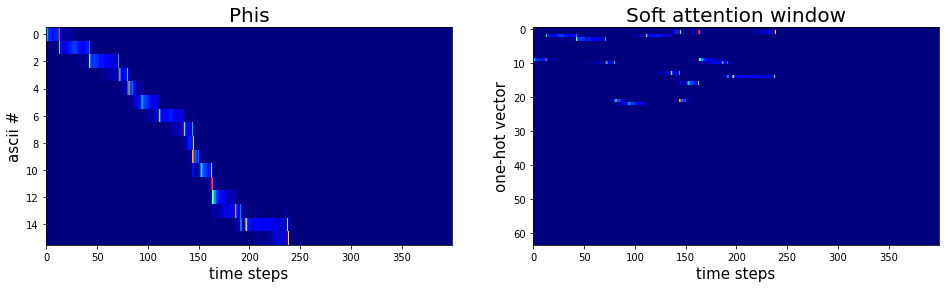

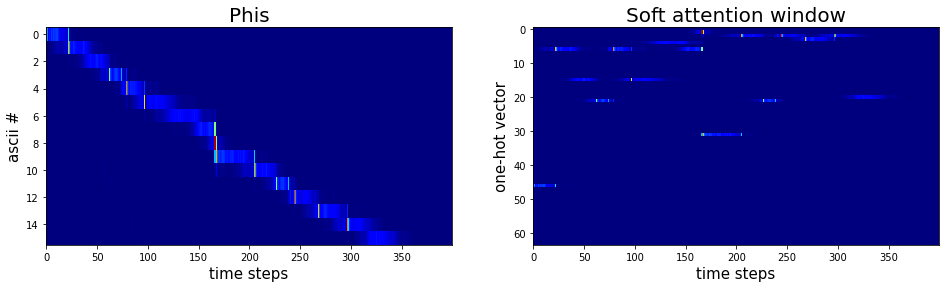

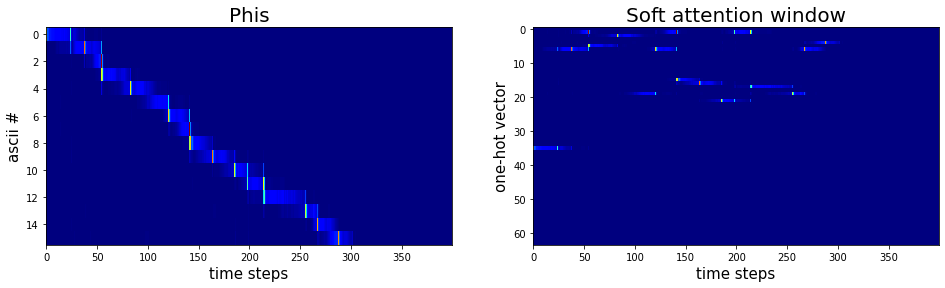

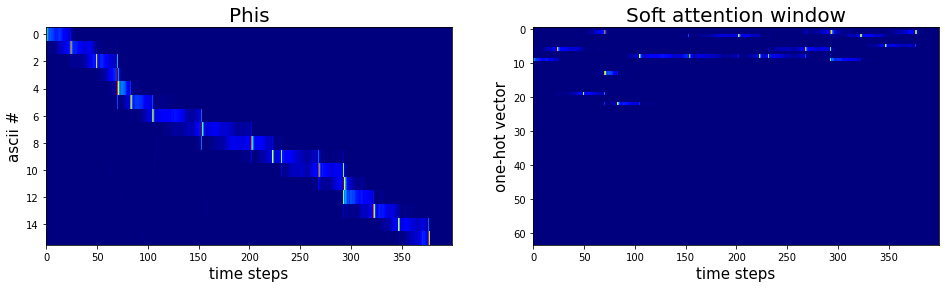

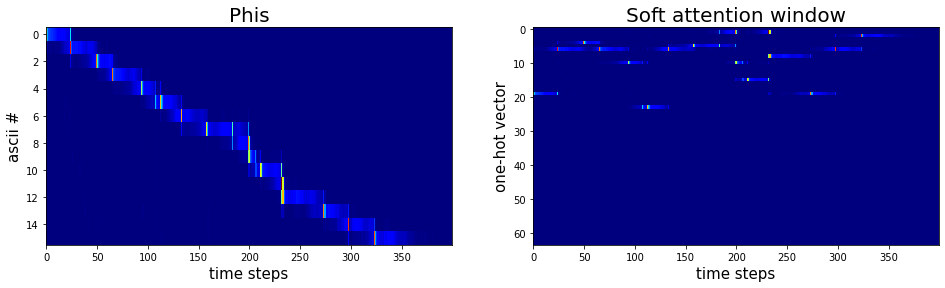

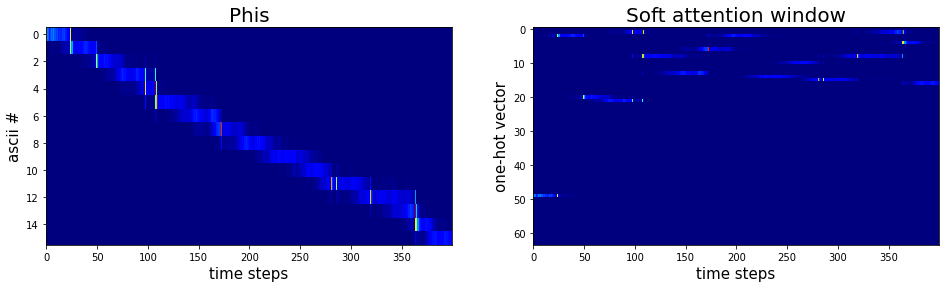

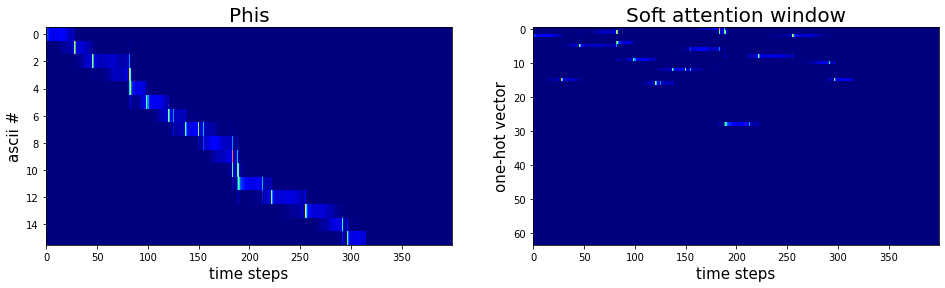

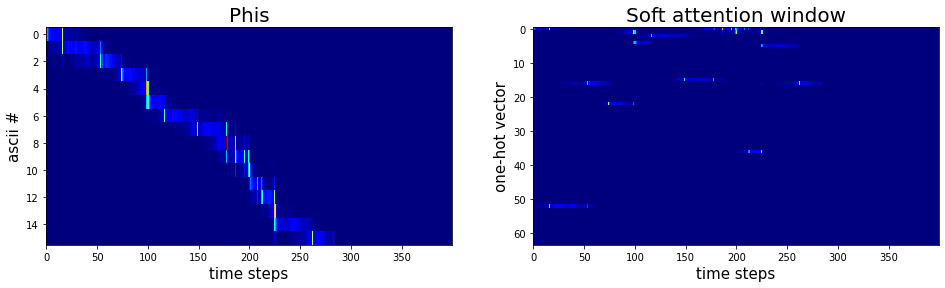

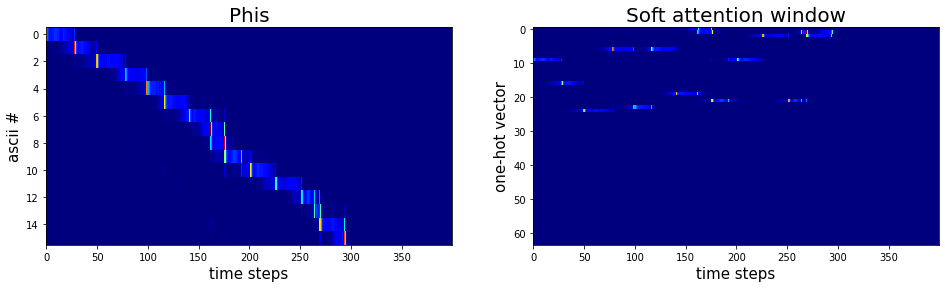

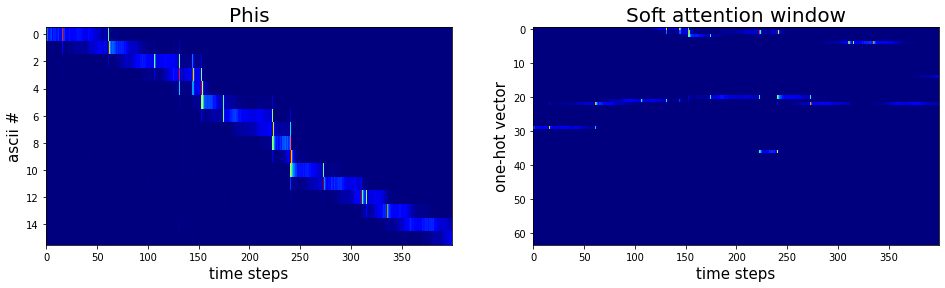

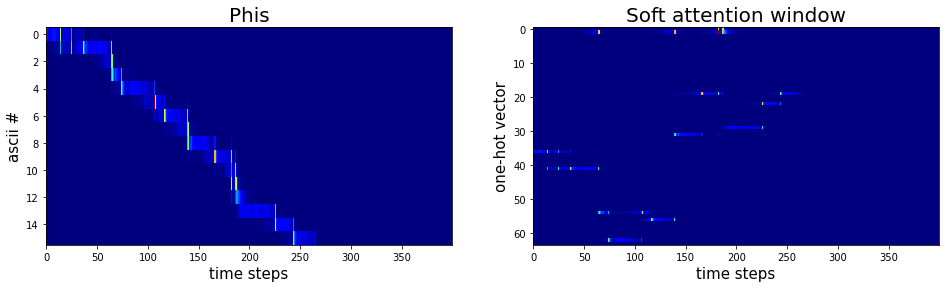

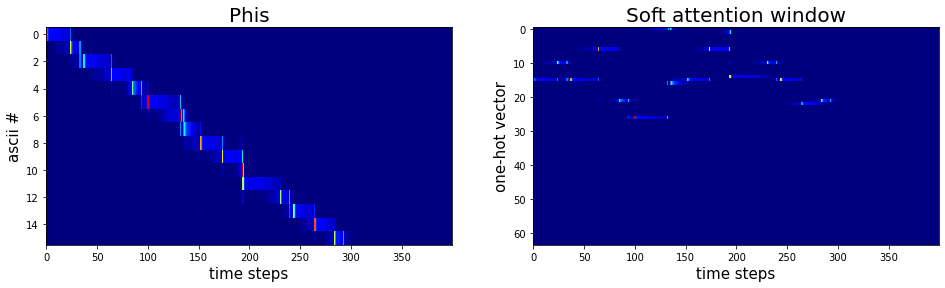

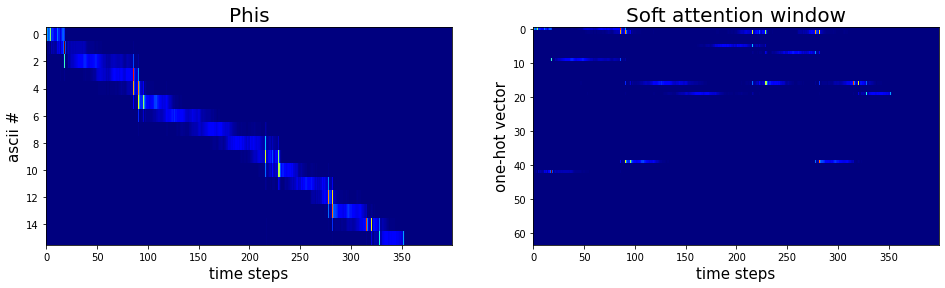

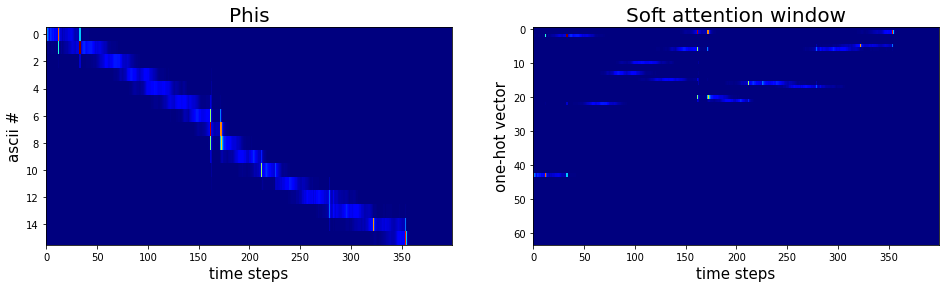

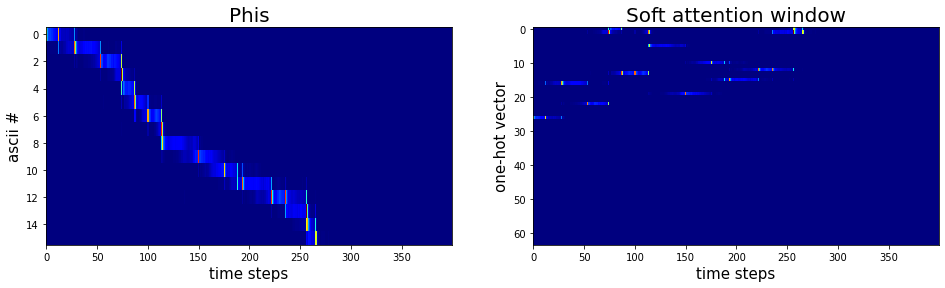

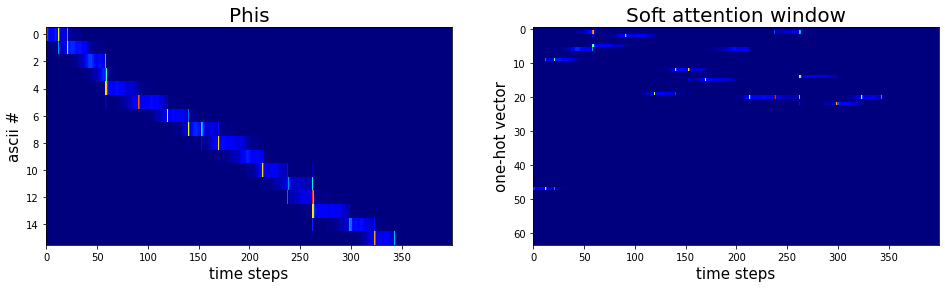

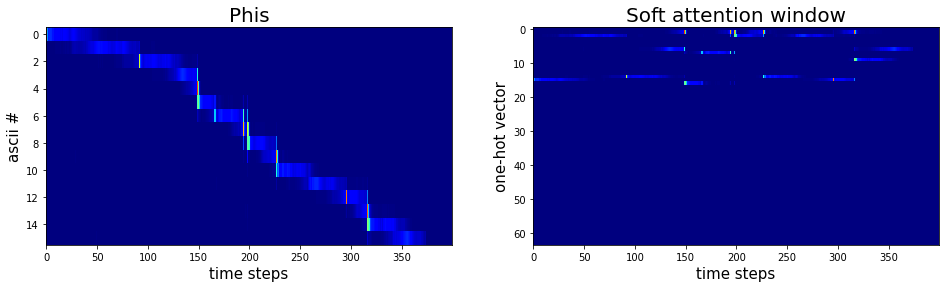

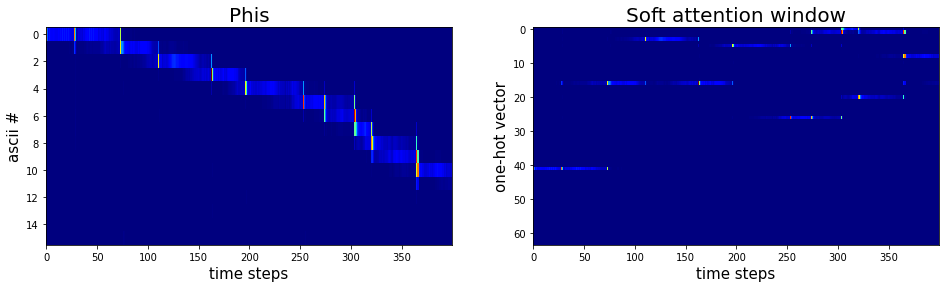

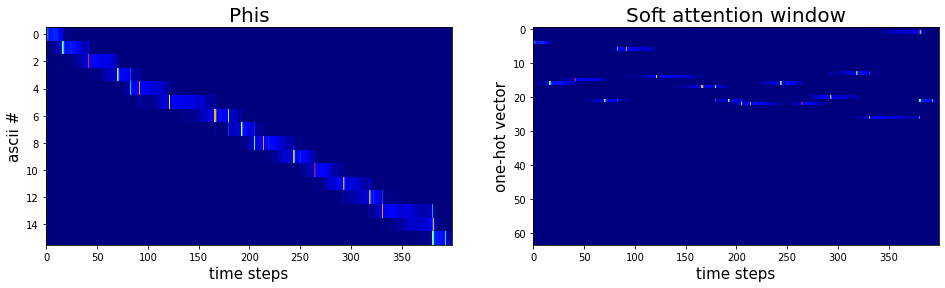

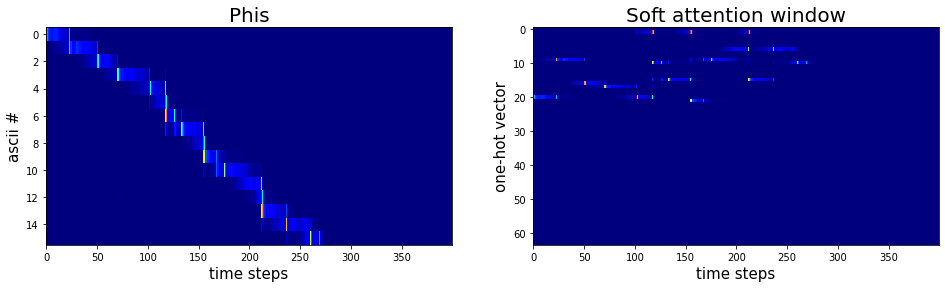

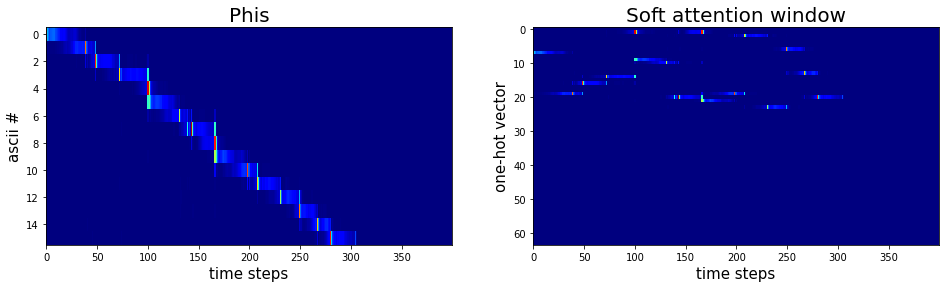

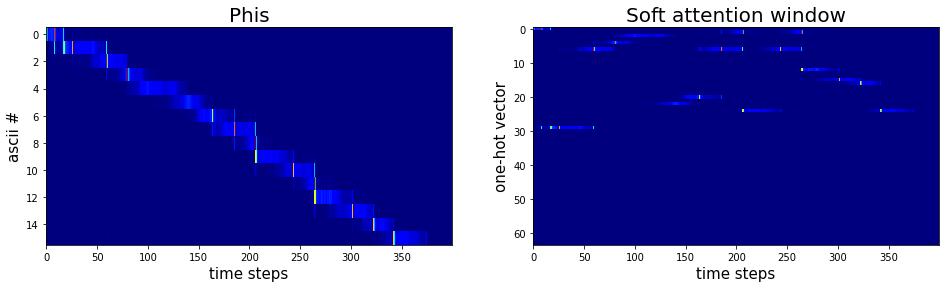

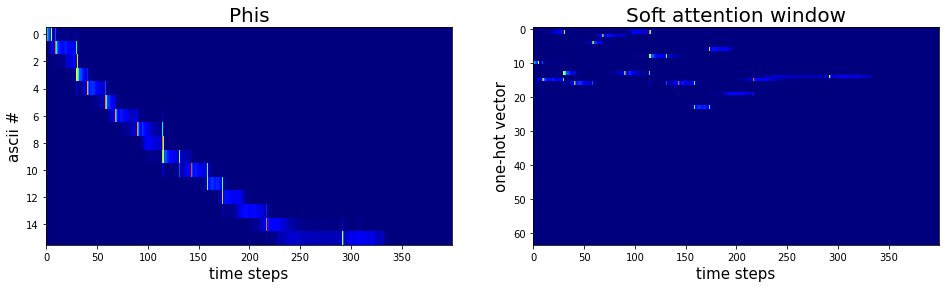

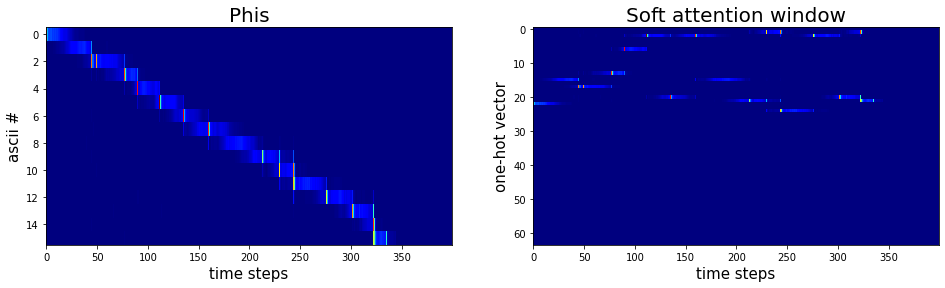

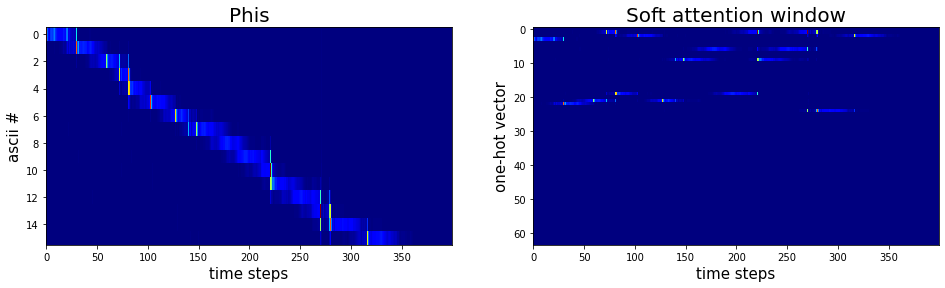

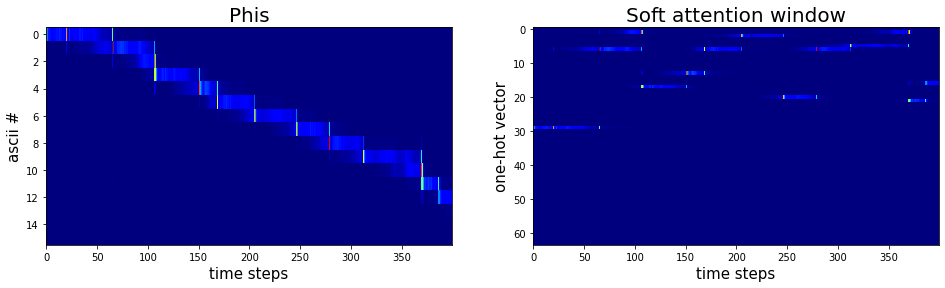

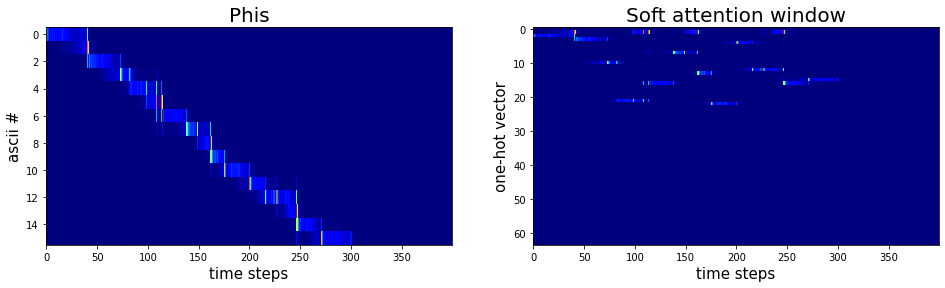

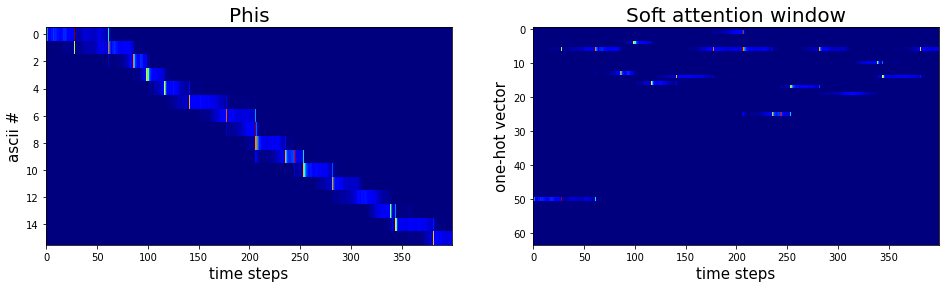

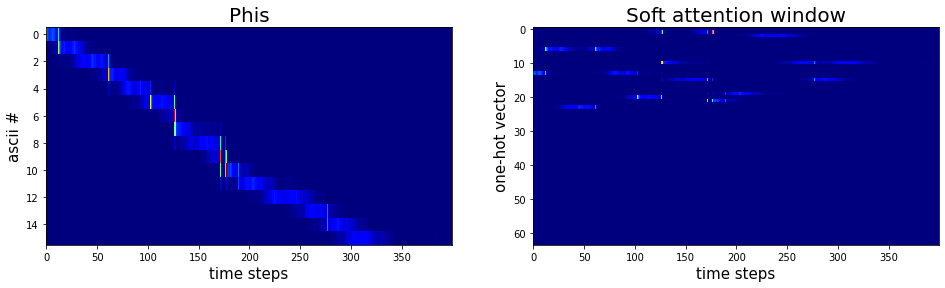

In [8]:
torch.cuda.empty_cache()
model = HandwritingSynthesisModel(hidden_size, n_gaussians, Kmixtures, dropout)
model.load_state_dict(torch.load("./models/synthesis.py"))
model.eval()

model = train_network(model, epochs = 50, generate = True)




In [ ]:
bias = 10

c0 = np.float32(one_hot("writing is hard!"))
c0 = torch.from_numpy(c0) 
c0 = torch.unsqueeze(c0, 0) # torch.Size(n_batch, U_items, len(alphabet))

model = HandwritingSynthesisModel(hidden_size, n_gaussians, Kmixtures, dropout)
model.load_state_dict(torch.load("./models/synthesis.py"))
model.eval()


x0 = torch.Tensor([0,0,1]).view(1,1,3)

if use_cuda:
    x0 = x0.cuda()
    c0 = c0.cuda()
    model = model.cuda()

for i in range(5):
    sequence = model.generate_sequence(x0, c0, bias)
    print(sequence.shape)
    draw_strokes_random_color(sequence, factor=0.5)

## Test cell

```Python
torch.cuda.empty_cache()

modelTest = HandwritingSynthesisModel(hidden_size, n_gaussians, Kmixtures, dropout)

data_loader = DataLoader(n_batch, sequence_length, 20, U_items=U_items) # 20 = datascale
x, y, s, c = data_loader.next_batch()
x = np.float32(np.array(x)) # -> (n_batch, sequence_length, 3)
y = np.float32(np.array(y)) # -> (n_batch, sequence_length, 3)
c = np.float32(np.array(c))

x = torch.from_numpy(x).permute(1, 0, 2) # torch.Size([sequence_length, n_batch, 3])
y = torch.from_numpy(y).permute(1, 0, 2) # torch.Size([sequence_length, n_batch, 3])
c = torch.from_numpy(c) # torch.Size(n_batch, U_items, len(alphabet))

if use_cuda:
    modelTest = modelTest.cuda()
    x = x.cuda()
    y = y.cuda()
    c = c.cuda()

es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos, Phis, Ws = modelTest.forward(x, c)


Pr = gaussianMixture(y, pis, mu1s, mu2s, sigma1s, sigma2s, rhos)
loss = loss_fn(Pr,y, es)

test = one_hot("Will it ever work ?")

x0 = torch.Tensor([0,0,1]).view(1,1,3)
c0 = np.float32(one_hot("Laurent estun PD"))
c0 = torch.from_numpy(c0) 
c0 = torch.unsqueeze(c0, 0) # torch.Size(n_batch, U_items, len(alphabet))

if use_cuda:
    x0 = x0.cuda()

sequence = model.generate_sequence(x0, c0, generate = True)
print(sequence.shape)
draw_strokes_random_color(sequence, factor=0.5)
```